<p style="font-size:3em">Classify marketplace's goods</p>

<br/>

This notebook corresponds to the first part of the **6th project of my data scientist path** with **OpenClassrooms/CentralSupelec** 

This project aims to provide the necessary skills to work on NLP and Image classification problems

This first notebook contains the data extracting and NLP parts :<br>

* Preprocessing (Lowercase, Tokenize, Stop Words, Lemming/Stemming
* Bag of Words and TF-IDF
* LDA and NMF topic modeling
* Non-supervise clustering based on TF-IDF results (via Kmeans)
* Word Embedding (via Doc2Vec)
* Transfer Learning test on Bert 
___
<b>I strongly recommend to use the 'table of content' extension of Jupyter to navigate through this notebook </b>

# Import 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

import nltk
from gensim.models import doc2vec
import re

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,silhouette_score,plot_confusion_matrix
from sklearn.decomposition import NMF, LatentDirichletAllocation, PCA,SparsePCA
from sklearn import cluster
from sklearn.manifold import TSNE

from sentence_transformers import SentenceTransformer

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [54]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

In [31]:
data = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

In [3]:
data.shape

(1050, 15)

In [7]:
data.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

# Keep useful feature + Train_test split

## Category cleaning

In this study, our target will be the product category. The initial category feature contains all category levels, we need to "explode" the current category feature so as to get each category.

In [162]:
for i in range(20): 
    print(data.iloc[0,4])
    print('\n')

["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]


["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]


["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]


["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]


["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]


["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]


["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]


["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]


["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Mu

In [4]:
data['product_category_tree']=data['product_category_tree'].str[2:-2]

In [5]:
data=data.join(data['product_category_tree'].str.split('\s*>>\s*', expand=True).add_prefix('category_'))
data

uniq_id            crawl_timestamp  \
0     55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1     7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2     64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3     d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4     6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   
...                                ...                        ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc  2015-12-01 10:15:43 +0000   
1046  fd6cbcc22efb6b761bd564c28928483c  2015-12-01 10:15:43 +0000   
1047  5912e037d12774bb73a2048f35a00009  2015-12-01 10:15:43 +0000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  2015-12-01 10:15:43 +0000   
1049  f2f027ad6a6df617c9f125173da71e44  2015-12-01 10:15:43 +0000   

                                            product_url  \
0     http://www.flipkart.com/elegance-polyester-mul...   
1     http://www.flipkart.com/sathiyas-cotton-bath-t...   
2     http://www.flipkart.com/eurospa-cotton-terry-f...   
3     http://www.flipkart.com/santosh-royal-fashion-...   
4     http://www.flipkart.com/jaipur-print-cotton-fl...   
...                                                 ...   
1045  http://www.flipkart.com/oren-empower-extra-lar...   
1046  http://www.flipkart.com/wallmantra-large-vinyl...   
1047  http://www.flipkart.com/uberlyfe-extra-large-p...   
1048  http://www.flipkart.com/wallmantra-medium-viny...   
1049  http://www.flipkart.com/uberlyfe-large-vinyl-s...   

                                           product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                  product_category_tree               pid  \
0     Home Furnishing >> Curtains & Accessories >> C...  CRNEG7BKMFFYHQ8Z   
1     Baby Care >> Baby Bath & Skin >> Baby Bath Tow...  BTWEGFZHGBXPHZUH   
2     Baby Care >> Baby Bath & Skin >> Baby Bath Tow...  BTWEG6SHXTDB2A2Y   
3     Home Furnishing >> Bed Linen >> Bedsheets >> S...  BDSEJT9UQWHDUBH4   
4     Home Furnishing >> Bed Linen >> Bedsheets >> J...  BDSEJTHNGWVGWWQU   
...                                                 ...               ...   
1045  Baby Care >> Baby & Kids Gifts >> Stickers >> ...  STIE88ZGTX65GH4V   
1046  Baby Care >> Baby & Kids Gifts >> Stickers >> ...  STIEC889ZD5GDCVQ   
1047  Baby Care >> Baby & Kids Gifts >> Stickers >> ...  STIE5UVGW2JWVWCT   
1048  Baby Care >> Baby & Kids Gifts >> Stickers >> ...  STIEC889ZGFD3RCE   
1049  Baby Care >> Baby & Kids Gifts >> Stickers >> ...  STIE2ZEPACRQJKH7   

      retail_price  discounted_price                                 image  \
0           1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1            600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2              NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3           2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4           2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   
...            ...               ...                                   ...   
1045        1399.0             999.0  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046        4930.0            1896.0  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047        4500.0            1449.0  5912e037d12774bb73a2048f35a00009.jpg   
1048        3465.0            1333.0  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

___

Here we can see that category_3 to _6 aren't filled in enough to be usable. We will focus on category_0 to _2 and try to assess which one will be our target

In [7]:
data['category_2']=data['category_2'].fillna(data['category_1'])
data.drop(columns=['category_3','category_4','category_5','category_6'],inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [14]:
print('Nb category_0: {}'.format(len(data.category_0.unique().tolist())))
data.category_0.unique().tolist()

Nb category_0: 7


['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

In [15]:
print('Nb category_1: {}'.format(len(data.category_1.unique().tolist())))
data.category_1.unique().tolist()

Nb category_1: 62


['Curtains & Accessories',
 'Baby Bath & Skin',
 'Bed Linen',
 'Wrist Watches',
 'Living Room Furnishing',
 'Bath Linen',
 'Candles & Fragrances',
 'Tableware & Cutlery',
 'Lighting',
 'JMD Home Furnishing',
 'Infant Wear',
 "Kripa's Home Furnishing",
 'Hair Care',
 'Coffee Mugs',
 'Network Components',
 'Tablet Accessories',
 'Cookware',
 'Laptop Accessories',
 'Makeup',
 'Combos and Kits',
 'Feeding & Nursing',
 'Baby Bedding',
 'Kitchen & Dining Linen',
 'Containers & Bottles',
 'Consumables & Disposables',
 'Wall Decor & Clocks',
 'Table Decor & Handicrafts',
 'Flowers, Plants & Vases',
 'Software',
 'Showpieces',
 'Furniture & Furnishings',
 'Decorative Lighting & Lamps',
 'Baby Grooming',
 'Computer Peripherals',
 'Cushions, Pillows & Covers',
 'Storage',
 'Health Care',
 'Body and Skin Care',
 'Kitchen Tools',
 'TRUE Home Decor & Festive Needs',
 'Living',
 'Showpiece',
 'Bar & Glassware',
 'Fragrances',
 "Women's Hygiene",
 'Diapering & Potty Training',
 'Strollers & Activity G

In [16]:
print('Nb category_2: {}'.format(len(data.category_2.unique().tolist())))
data.category_2.unique().tolist()

Nb category_2: 243


['Curtains',
 'Baby Bath Towels',
 'Bedsheets',
 'Maserati Time Wrist Watches',
 'Camerii Wrist Watches',
 'T STAR Wrist Watches',
 'Alfajr Wrist Watches',
 'TAG Heuer Wrist Watches',
 'Calibro Wrist Watches',
 'Cartier Wrist Watches',
 'Lois Caron Wrist Watches',
 'Titan Wrist Watches',
 'Srushti Art Jewelry Wrist Watches',
 'Escort Wrist Watches',
 'Jack klein Wrist Watches',
 'North Moon Wrist Watches',
 'Franck Bella Wrist Watches',
 'Ridas Wrist Watches',
 'Skmei Wrist Watches',
 'Now Wrist Watches',
 'fastrack Wrist Watches',
 'Disney Wrist Watches',
 'Vizion Wrist Watches',
 'Elantra Wrist Watches',
 'Marvel Wrist Watches',
 'Lenco Wrist Watches',
 "D'Signer Wrist Watches",
 'Diwan Sets',
 'Duvet Covers',
 'Bath Mats',
 'Home Fragrances',
 'Jug, Glass & Tray Sets',
 'Bulbs',
 'JMD Printed Cushions Cover (Pack of 2, 40 cm*40 ...',
 "Baby Girls' Clothes",
 "Kripa's Printed Cushions Cover (Pack of 2, 45 cm...",
 'Conditioners',
 'AKUP Coffee Mugs',
 'Routers',
 'Keyboards',
 'Casse

## Overview Categories

### Overview Category_0

In [12]:
pie_data = pd.DataFrame(data['category_0'].value_counts())
pie_data

category
Kitchen & Dining                 150
Baby Care                        150
Home Decor & Festive Needs       150
Beauty and Personal Care         150
Computers                        150
Watches                          150
Home Furnishing                  150

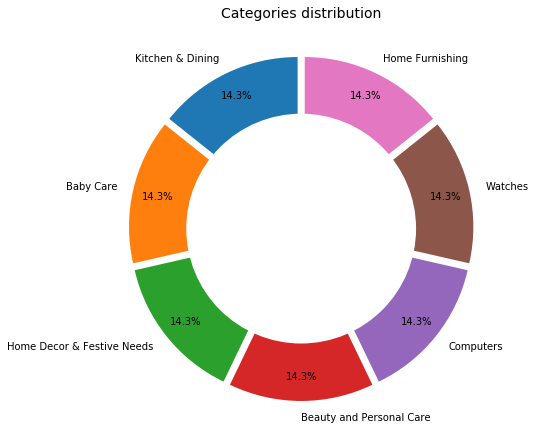

In [14]:
labels = pie_data.index
sizes = pie_data.category

#explsion
explode = [0.05]*pie_data.shape[0]

plt.figure(figsize=[10,6])
plt.pie(sizes,labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
 
plt.tight_layout()
plt.title('Categories distribution',fontsize=14)
plt.show()

### Overview Category_1 

In [23]:
pie_data = pd.DataFrame(data['category_1'].value_counts())
pie_data

category
Wrist Watches                   149
Laptop Accessories               87
Infant Wear                      84
Coffee Mugs                      74
Showpieces                       71
...                             ...
Men's Grooming                    1
Kripa's Home Furnishing           1
Dinnerware & Crockery             1
Consumables & Disposables         1
Garden & Leisure                  1

[62 rows x 1 columns]

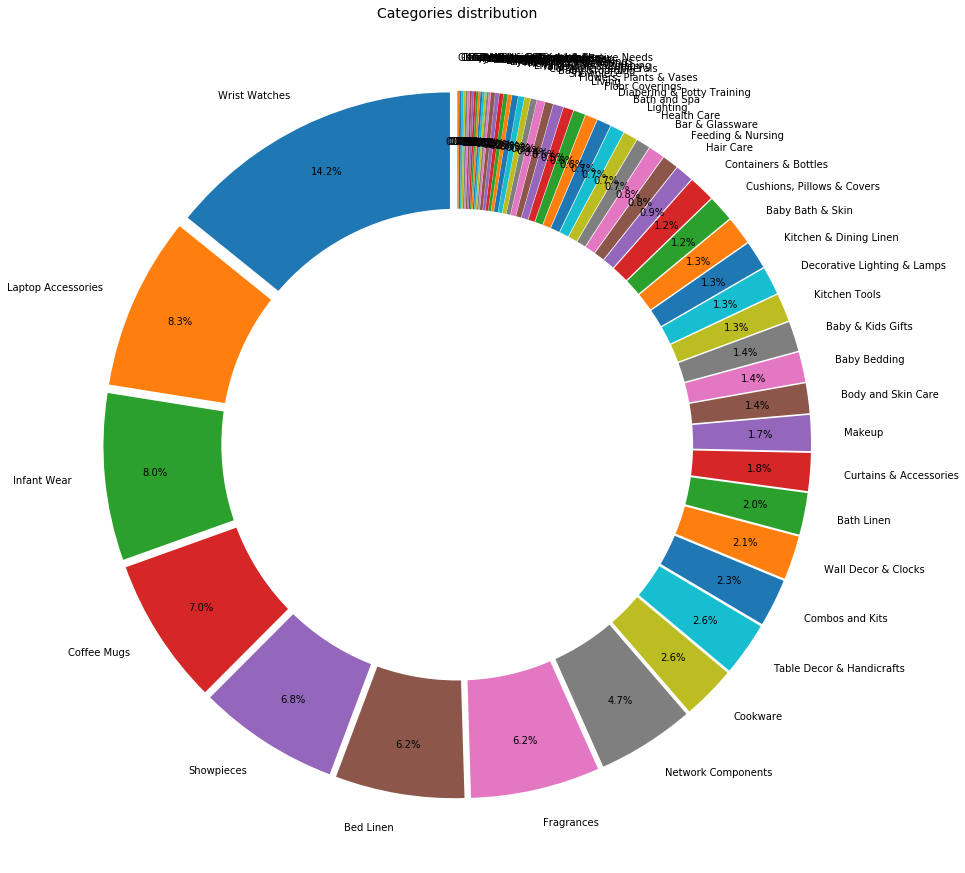

In [35]:
labels = pie_data.index
sizes = pie_data.category

#explsion
explode = [0.05]*pie_data.shape[0]

plt.figure(figsize=[15,12])
plt.pie(sizes,labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
 
plt.tight_layout()
plt.title('Categories distribution',fontsize=14)
plt.show()

In [25]:
threshold= 2/100*pie_data.values.sum()

In [26]:
to_merge=pie_data.loc[pie_data['category']<threshold]
to_merge.category.sum()

285

In [27]:
to_merge

category
Curtains & Accessories                 19
Makeup                                 18
Body and Skin Care                     15
Baby Bedding                           15
Baby & Kids Gifts                      15
Kitchen Tools                          14
Decorative Lighting & Lamps            14
Kitchen & Dining Linen                 14
Baby Bath & Skin                       14
Cushions, Pillows & Covers             13
Containers & Bottles                   13
Hair Care                               9
Feeding & Nursing                       8
Bar & Glassware                         8
Health Care                             7
Lighting                                7
Bath and Spa                            7
Diapering & Potty Training              7
Floor Coverings                         6
Living                                  6
Flowers, Plants & Vases                 5
Showpiece                               5
Baby Grooming                           4
Computer Peripherals                    4
Tableware & Cutlery                     3
Living Room Furnishing                  3
Religion & Devotion                     3
Tablet Accessories                      3
Furniture & Furnishings                 2
Eye Care                                2
Laptops                                 2
Computer Components                     2
Storage                                 2
Beauty Accessories                      1
Strollers & Activity Gear               1
Software                                1
Women's Hygiene                         1
JMD Home Furnishing                     1
Pressure Cookers & Pans                 1
Housekeeping & Laundry                  1
TRUE Home Decor & Festive Needs         1
Clocks                                  1
Candles & Fragrances                    1
Tidy Home Furnishing                    1
Men's Grooming                          1
Kripa's Home Furnishing                 1
Dinnerware & Crockery                   1
Consumables & Disposables               1
Garden & Leisure                        1

In [28]:
pie_data_other=pie_data.loc[pie_data['category']>=threshold]
pie_data_other.loc['Other','category']=to_merge.category.sum()


C:\Users\quent\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


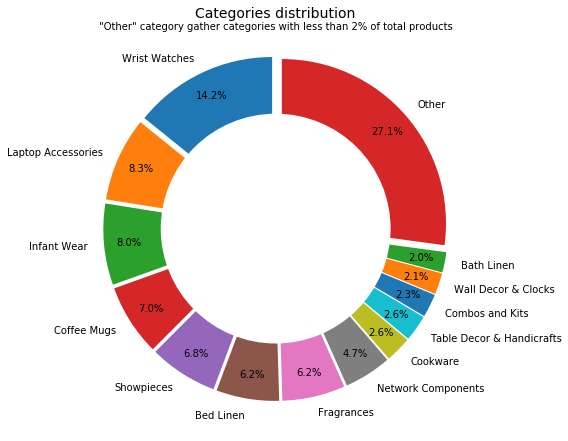

In [36]:
labels = pie_data_other.index
sizes = pie_data_other.category

#explsion
explode = [0.05]*pie_data_other.shape[0]

plt.figure(figsize=[10,6])
plt.pie(sizes,labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
 
plt.tight_layout()
plt.title('Categories distribution',fontsize=14)
plt.suptitle('"Other" category gather categories with less than 2% of total products',fontsize=10)
plt.show()

For our study we will keep category_0, the goal here is to provide a "proof of concept", it will be way easier to work with targets evenly allocated
___
<p style="font-size:17px"><b>We can now keep in mind that one category correspond to <font color='red'> 14.3%</font> of our dataset, this will represent our baseline in terms of classification accuracy </b></p>

## Keep Category + Description + Image

In [17]:
data 

uniq_id            crawl_timestamp  \
0     55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1     7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2     64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3     d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4     6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   
...                                ...                        ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc  2015-12-01 10:15:43 +0000   
1046  fd6cbcc22efb6b761bd564c28928483c  2015-12-01 10:15:43 +0000   
1047  5912e037d12774bb73a2048f35a00009  2015-12-01 10:15:43 +0000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  2015-12-01 10:15:43 +0000   
1049  f2f027ad6a6df617c9f125173da71e44  2015-12-01 10:15:43 +0000   

                                            product_url  \
0     http://www.flipkart.com/elegance-polyester-mul...   
1     http://www.flipkart.com/sathiyas-cotton-bath-t...   
2     http://www.flipkart.com/eurospa-cotton-terry-f...   
3     http://www.flipkart.com/santosh-royal-fashion-...   
4     http://www.flipkart.com/jaipur-print-cotton-fl...   
...                                                 ...   
1045  http://www.flipkart.com/oren-empower-extra-lar...   
1046  http://www.flipkart.com/wallmantra-large-vinyl...   
1047  http://www.flipkart.com/uberlyfe-extra-large-p...   
1048  http://www.flipkart.com/wallmantra-medium-viny...   
1049  http://www.flipkart.com/uberlyfe-large-vinyl-s...   

                                           product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                  product_category_tree               pid  \
0     Home Furnishing >> Curtains & Accessories >> C...  CRNEG7BKMFFYHQ8Z   
1     Baby Care >> Baby Bath & Skin >> Baby Bath Tow...  BTWEGFZHGBXPHZUH   
2     Baby Care >> Baby Bath & Skin >> Baby Bath Tow...  BTWEG6SHXTDB2A2Y   
3     Home Furnishing >> Bed Linen >> Bedsheets >> S...  BDSEJT9UQWHDUBH4   
4     Home Furnishing >> Bed Linen >> Bedsheets >> J...  BDSEJTHNGWVGWWQU   
...                                                 ...               ...   
1045  Baby Care >> Baby & Kids Gifts >> Stickers >> ...  STIE88ZGTX65GH4V   
1046  Baby Care >> Baby & Kids Gifts >> Stickers >> ...  STIEC889ZD5GDCVQ   
1047  Baby Care >> Baby & Kids Gifts >> Stickers >> ...  STIE5UVGW2JWVWCT   
1048  Baby Care >> Baby & Kids Gifts >> Stickers >> ...  STIEC889ZGFD3RCE   
1049  Baby Care >> Baby & Kids Gifts >> Stickers >> ...  STIE2ZEPACRQJKH7   

      retail_price  discounted_price                                 image  \
0           1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1            600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2              NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3           2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4           2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   
...            ...               ...                                   ...   
1045        1399.0             999.0  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046        4930.0            1896.0  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047        4500.0            1449.0  5912e037d12774bb73a2048f35a00009.jpg   
1048        3465.0            1333.0  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1

In [8]:
to_split= data.reindex(columns=['category_0','description','image'])
to_split.rename(columns={'category_0':'category'},inplace=True)
to_split

category                                        description  \
0     Home Furnishing  Key Features of Elegance Polyester Multicolor ...   
1           Baby Care  Specifications of Sathiyas Cotton Bath Towel (...   
2           Baby Care  Key Features of Eurospa Cotton Terry Face Towe...   
3     Home Furnishing  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4     Home Furnishing  Key Features of Jaipur Print Cotton Floral Kin...   
...               ...                                                ...   
1045        Baby Care  Oren Empower Extra Large Self Adhesive Sticker...   
1046        Baby Care  Wallmantra Large Vinyl Sticker Sticker (Pack o...   
1047        Baby Care  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...   
1048        Baby Care  Buy Wallmantra Medium Vinyl Sticker Sticker fo...   
1049        Baby Care  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...   

                                     image  
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg  
1     7b72c92c2f6c40268628ec5f14c6d590.jpg  
2     64d5d4a258243731dc7bbb1eef49ad74.jpg  
3     d4684dcdc759dd9cdf41504698d737d8.jpg  
4     6325b6870c54cd47be6ebfbffa620ec7.jpg  
...                                    ...  
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg  
1046  fd6cbcc22efb6b761bd564c28928483c.jpg  
1047  5912e037d12774bb73a2048f35a00009.jpg  
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg  
1049  f2f027ad6a6df617c9f125173da71e44.jpg  

[1050 rows x 3 columns]

In [9]:
to_split.dtypes

category       object
description    object
image          object
dtype: object

In [10]:
to_split.description=to_split.description.astype('string')

In [11]:
to_split

category                                        description  \
0     Home Furnishing  Key Features of Elegance Polyester Multicolor ...   
1           Baby Care  Specifications of Sathiyas Cotton Bath Towel (...   
2           Baby Care  Key Features of Eurospa Cotton Terry Face Towe...   
3     Home Furnishing  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4     Home Furnishing  Key Features of Jaipur Print Cotton Floral Kin...   
...               ...                                                ...   
1045        Baby Care  Oren Empower Extra Large Self Adhesive Sticker...   
1046        Baby Care  Wallmantra Large Vinyl Sticker Sticker (Pack o...   
1047        Baby Care  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...   
1048        Baby Care  Buy Wallmantra Medium Vinyl Sticker Sticker fo...   
1049        Baby Care  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...   

                                     image  
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg  
1     7b72c92c2f6c40268628ec5f14c6d590.jpg  
2     64d5d4a258243731dc7bbb1eef49ad74.jpg  
3     d4684dcdc759dd9cdf41504698d737d8.jpg  
4     6325b6870c54cd47be6ebfbffa620ec7.jpg  
...                                    ...  
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg  
1046  fd6cbcc22efb6b761bd564c28928483c.jpg  
1047  5912e037d12774bb73a2048f35a00009.jpg  
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg  
1049  f2f027ad6a6df617c9f125173da71e44.jpg  

[1050 rows x 3 columns]

In [22]:
to_split.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     1050 non-null   object
 1   description  1050 non-null   string
 2   image        1050 non-null   object
dtypes: object(2), string(1)
memory usage: 24.7+ KB


## Train_Test split

In [17]:
# Split train_test with keeping the categories distribution

train,test = train_test_split(to_split,
                              test_size=0.20,
                              stratify=to_split.category)


In [18]:
train.category.value_counts()

Kitchen & Dining              120
Baby Care                     120
Home Decor & Festive Needs    120
Beauty and Personal Care      120
Computers                     120
Watches                       120
Home Furnishing               120
Name: category, dtype: int64

In [22]:
train.dtypes

category       object
description    string
image          object
dtype: object

In [31]:
train

category  \
582               Wrist Watches   
896  Cushions, Pillows & Covers   
759               Wrist Watches   
931                   Bed Linen   
817                   Bed Linen   
..                          ...   
984   Table Decor & Handicrafts   
516               Wrist Watches   
408                  Fragrances   
609            Garden & Leisure   
722                   Bed Linen   

                                           description  \
582  Flippd FD040149 Casual Analog Watch  - For Wom...   
896  Rustic India Geometric Cushions Cover (Pack of...   
759  Fighter FIGH_008 Digital Watch  - For Couple -...   
931  Buy Jaipur Textile Hub Floral Double Quilts & ...   
817  Buy Raymond Abstract Double Blanket Red at Rs....   
..                                                 ...   
984  Buy Art Godaam Colored figure Showpiece  -  50...   
516  Sonata 7016YM09 Watch - Buy Sonata 7016YM09 Wa...   
408  Wild Stone Deodorant No-22 Combo Set (Set of 2...   
609  Key Features of Rrsskids Swing King Cotton Ham...   
722  Sapatos Plain Single Duvet Red (Single duvet)
...   

                                    image  
582  a7bd63ef1d3b345d7f9a162865bb7c0d.jpg  
896  2eb07dc77e2fc7e3668fd7ed9b864039.jpg  
759  e80e5151787eb21b0cca0d7dc3b0c338.jpg  
931  60395c709b4a933319e2713e3ae620d4.jpg  
817  fc59187b2e011cf098ce420a0ee02e10.jpg  
..                                    ...  
984  357432a848c3f13fa614efe5dddd99b6.jpg  
516  d77279c8268e231b685cdbaf299e83f2.jpg  
408  a7a294ddbcd9bbbc46c034079529c17c.jpg  
609  08bdf59c9dcb241e3a57eb4f3729ec70.jpg  
722  7091af252a785131c5a124fb90705fda.jpg  

[840 rows x 3 columns]

In [32]:
test

category  \
130                  Coffee Mugs   
90                    Showpieces   
877                   Bath Linen   
341           Network Components   
337                   Fragrances   
..                           ...   
957  Decorative Lighting & Lamps   
125           Body and Skin Care   
932                    Bed Linen   
675             Baby Bath & Skin   
482           Laptop Accessories   

                                           description  \
130  Rockmantra Old Art Ceramic Mug (5.5 l)
      ...   
90   Buy Exotic India Adi Buddha Vajrasattva Showpi...   
877  Buy Nkp Cotton Bath Towel at Rs. 549 at Flipka...   
341  Buy Belkin Share Modem (N) Router only for Rs....   
337  Flipkart.com: Buy Arabian Nights Evolve Combo ...   
..                                                 ...   
957  Key Features of Nutcase Multicolor Column Floo...   
125  Flipkart.com: Buy Sally Hansen La Cross 5 Pcs ...   
932  Buy Valtellina Abstract Double Blanket Brown a...   
675  Buy BabyBucket Cotton Bath Towel at Rs. 735 at...   
482  Buy ARB HP Pavilion dv5t-1000 Replacement 6 Ce...   

                                    image  
130  f01ff0a82401117e9da22dd680fd2f36.jpg  
90   6ae332e2bafd23267caedfcc4453257c.jpg  
877  c943647eee4de99fc1b4e233b9a7f47d.jpg  
341  fce2bd96b35d531a4784bc57e19aca4f.jpg  
337  7680c6bf930669dc0646e3315187dc8c.jpg  
..                                    ...  
957  e488005c7fb68747d3458c7d73760bae.jpg  
125  7241df1acae1fac892c692097ea3fb98.jpg  
932  cf1be83386eb96b2ab9598944ebca6fc.jpg  
675  7f6678a6217c831b716feca796f689fd.jpg  
482  a76bf8400b3dbcdbe5a5678f4a8ea0f6.jpg  

[210 rows x 3 columns]

In [19]:
train.to_csv (r'C:\Users\quent\Desktop\Formation_OCR\Projets\Projet_6\train.csv', index = False, header=True)
test.to_csv (r'C:\Users\quent\Desktop\Formation_OCR\Projets\Projet_6\test.csv', index = False, header=True)

# Preprocessing analysis

In [25]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [20]:
train

category  \
111   Home Decor & Festive Needs   
1010                   Baby Care   
459     Beauty and Personal Care   
889                    Baby Care   
707              Home Furnishing   
...                          ...   
845                    Baby Care   
152             Kitchen & Dining   
125     Beauty and Personal Care   
702   Home Decor & Festive Needs   
524                      Watches   

                                            description  \
111   Specifications of Eternity Handcrafted unique ...   
1010  Key Features of Dongli Striped Baby Boy's Polo...   
459   Key Features of TIGI BED HEAD COLOUR GODDESS O...   
889   Buy Intex Kids Inflatable Air Chair for Rs.429...   
707   Buy Home Originals Polka, Abstract Double Blan...   
...                                                 ...   
845   Feetje Trousers - Buy Blue Feetje Trousers For...   
152   Buy Prithish Abstract Design 21 Ceramic Mug fo...   
125   Flipkart.com: Buy Sally Hansen La Cross 5 Pcs ...   
702   Buy Jaipur Raga Lord Krishna Showpiece  -  14 ...   
524   Noise NOSWW001 Analog Watch  - For Men, Women ...   

                                     image  
111   0bb0f7b7a3075f4b9459121abe2185fa.jpg  
1010  9ff54c12cc7ffd7c1a6724477b8fea2f.jpg  
459   4e09d5a71d46d61de3d4c9c5aedb73f2.jpg  
889   b454f9f449c9dff58b90113ba984ea98.jpg  
707   ff24511994fc459d04145231c8876d6c.jpg  
...                                    ...  
845   9e90fb6c7870637b6f794e4b4c26bd7e.jpg  
152   ec590694e8bf85f75c9200cf418127aa.jpg  
125   7241df1acae1fac892c692097ea3fb98.jpg  
702   1218fd9be42d45a81846db9f65a983bd.jpg  
524   797d10fe966b3aa35933669c3425525b.jpg  

[840 rows x 3 columns]

In [37]:
train.iloc[0,1]

'Flippd FD040149 Casual Analog Watch  - For Women, Girls - Buy Flippd FD040149 Casual Analog Watch  - For Women, Girls  FD040149 Online at Rs.999 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!'

In [30]:
train.iloc[18,1]

'Buy Gift Studios Buddha Stone Showpiece  -  17.6 cm for Rs.699 online. Gift Studios Buddha Stone Showpiece  -  17.6 cm at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.'

For now we have a long string which cannot be used by any algorithm in its current state, we need to proceed with a few preprocessing steps

## Lowercase

First preprocessing step : lowercase the entire text

In [23]:
train['description']=train['description'].str.lower()

C:\Users\quent\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Tokenize

In [24]:
train.iloc[0,1]

'specifications of eternity handcrafted unique mosaic glass table lamp (35 cm, blue) in the box sales package 1 table lamp number of contents in sales package pack of 1 general type buffet, desk color blue lamp body material glass lamp base material metal bulb type 1x15 led, cfsl ,bulb light color blue assembly required no model name handcrafted unique mosaic glass model number eternity001007 power features power requirement 110-240v, 50/60hz power source ac additional features handcrafted\xa0lamps dimensions width 15 cm height 35 cm weight 1000 g'

Create a tokenizer base on regular expression '\w+' which will take any group of [0-9] and [a-z] character

In [26]:
tokenizer = nltk.RegexpTokenizer(r'\w+')
tokenizer.tokenize(train.iloc[0,1])

['specifications',
 'of',
 'eternity',
 'handcrafted',
 'unique',
 'mosaic',
 'glass',
 'table',
 'lamp',
 '35',
 'cm',
 'blue',
 'in',
 'the',
 'box',
 'sales',
 'package',
 '1',
 'table',
 'lamp',
 'number',
 'of',
 'contents',
 'in',
 'sales',
 'package',
 'pack',
 'of',
 '1',
 'general',
 'type',
 'buffet',
 'desk',
 'color',
 'blue',
 'lamp',
 'body',
 'material',
 'glass',
 'lamp',
 'base',
 'material',
 'metal',
 'bulb',
 'type',
 '1x15',
 'led',
 'cfsl',
 'bulb',
 'light',
 'color',
 'blue',
 'assembly',
 'required',
 'no',
 'model',
 'name',
 'handcrafted',
 'unique',
 'mosaic',
 'glass',
 'model',
 'number',
 'eternity001007',
 'power',
 'features',
 'power',
 'requirement',
 '110',
 '240v',
 '50',
 '60hz',
 'power',
 'source',
 'ac',
 'additional',
 'features',
 'handcrafted',
 'lamps',
 'dimensions',
 'width',
 '15',
 'cm',
 'height',
 '35',
 'cm',
 'weight',
 '1000',
 'g']

In [27]:
# Tokenize all the descriptions in train dataset
tokenizer = nltk.RegexpTokenizer(r'\w+')
train['description']=train['description'].apply(lambda x: str(tokenizer.tokenize(x)))

C:\Users\quent\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
train

category  \
111   Home Decor & Festive Needs   
1010                   Baby Care   
459     Beauty and Personal Care   
889                    Baby Care   
707              Home Furnishing   
...                          ...   
845                    Baby Care   
152             Kitchen & Dining   
125     Beauty and Personal Care   
702   Home Decor & Festive Needs   
524                      Watches   

                                            description  \
111   ['specifications', 'of', 'eternity', 'handcraf...   
1010  ['key', 'features', 'of', 'dongli', 'striped',...   
459   ['key', 'features', 'of', 'tigi', 'bed', 'head...   
889   ['buy', 'intex', 'kids', 'inflatable', 'air', ...   
707   ['buy', 'home', 'originals', 'polka', 'abstrac...   
...                                                 ...   
845   ['feetje', 'trousers', 'buy', 'blue', 'feetje'...   
152   ['buy', 'prithish', 'abstract', 'design', '21'...   
125   ['flipkart', 'com', 'buy', 'sally', 'hansen', ...   
702   ['buy', 'jaipur', 'raga', 'lord', 'krishna', '...   
524   ['noise', 'nosww001', 'analog', 'watch', 'for'...   

                                     image  
111   0bb0f7b7a3075f4b9459121abe2185fa.jpg  
1010  9ff54c12cc7ffd7c1a6724477b8fea2f.jpg  
459   4e09d5a71d46d61de3d4c9c5aedb73f2.jpg  
889   b454f9f449c9dff58b90113ba984ea98.jpg  
707   ff24511994fc459d04145231c8876d6c.jpg  
...                                    ...  
845   9e90fb6c7870637b6f794e4b4c26bd7e.jpg  
152   ec590694e8bf85f75c9200cf418127aa.jpg  
125   7241df1acae1fac892c692097ea3fb98.jpg  
702   1218fd9be42d45a81846db9f65a983bd.jpg  
524   797d10fe966b3aa35933669c3425525b.jpg  

[840 rows x 3 columns]

## Stop Words

The next step will be to remove too-common words which will be useless for us, such as "the, me, I, you, ...". <br>
To do this we can use an english stop words list from nltk <br>
We will also try to assess whether it is interesting to add some common words in our own problematic (words like "product, prize, delivery, ...")

In [29]:
# Corpus will contain each and every remaining words of our dataset

corpus=[]
for i in range(train.shape[0]):
    corpus=corpus+eval(train.iloc[i,1])

In [30]:
len(corpus)

64878

In [33]:
# corpus_freq will be a dictionnary containing each word of our dataset along with its frequency 

corpus_freq = nltk.FreqDist(corpus)

In [34]:
corpus_freq

FreqDist({'of': 1390, 'for': 1150, 'and': 1072, 'the': 1039, 'to': 855, 'in': 829, 'rs': 726, 'only': 703, 'with': 669, 'on': 649, ...})

In [43]:
d = dict((k, v) for k, v in corpus_freq.items() if v <= 5)
len(d.values())

3868

In [35]:
# Save our corpus_freq 

with open('corpus_freq.pickle', 'wb') as file:
    pickle.dump(corpus_freq, file)

In [16]:
# with open('corpus_freq.pickle', 'rb') as file:
#         corpus_freq=pickle.load(file)

In [112]:
# Overview of the most_common words of our corpus

common_words.most_common(39)

[('of', 1443),
 ('for', 1118),
 ('the', 1089),
 ('and', 1071),
 ('in', 858),
 ('to', 852),
 ('rs', 729),
 ('with', 712),
 ('only', 699),
 ('on', 658),
 ('at', 581),
 ('your', 544),
 ('is', 524),
 ('a', 522),
 ('products', 501),
 ('free', 493),
 ('buy', 458),
 ('genuine', 446),
 ('shipping', 446),
 ('cash', 446),
 ('delivery', 446),
 ('1', 442),
 ('replacement', 441),
 ('cm', 434),
 ('day', 426),
 ('30', 398),
 ('guarantee', 374),
 ('flipkart', 365),
 ('com', 362),
 ('it', 361),
 ('this', 352),
 ('online', 325),
 ('features', 325),
 ('from', 308),
 ('s', 306),
 ('specifications', 296),
 ('price', 289),
 ('you', 285),
 ('color', 280)]

After looking at the 50-70 most common words, it looks like aroung the 40th we start to see specific words related to category such as mug or watches, we will create a list containing the 39 most common word, so as to be able to assess later if this list of stop words can provide better results 

In [113]:
common_words,freq=zip(*common_words.most_common(39))

In [97]:
common_words

('of',
 'for',
 'the',
 'and',
 'in',
 'to',
 'rs',
 'with',
 'only',
 'on',
 'at',
 'your',
 'is',
 'a',
 'products',
 'free',
 'buy',
 'genuine',
 'shipping',
 'cash',
 'delivery',
 '1',
 'replacement',
 'cm',
 'day',
 '30',
 'guarantee',
 'flipkart',
 'com',
 'it',
 'this',
 'online',
 'features',
 'from',
 's',
 'specifications',
 'price',
 'you',
 'color',
 'mug',
 'baby',
 'watch',
 'pack',
 'cotton',
 'set',
 'material',
 'type',
 'box',
 'general',
 '5')

### Check the first entry of our dataset withou common words and english stop words

In [44]:
englis_stopwords = nltk.corpus.stopwords.words('english')

In [115]:
englis_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [116]:
sw=set()
sw.update(common_words)
sw.update(tuple(englis_stopwords))

In [117]:
sw

{'1',
 '30',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'buy',
 'by',
 'can',
 'cash',
 'cm',
 'color',
 'com',
 'couldn',
 "couldn't",
 'd',
 'day',
 'delivery',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'features',
 'few',
 'flipkart',
 'for',
 'free',
 'from',
 'further',
 'genuine',
 'guarantee',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 

In [126]:
with open('sw.pickle', 'wb') as file:
    pickle.dump(sw, file)

In [118]:
eval(train.iloc[0,1])

['flippd',
 'fd040149',
 'casual',
 'analog',
 'watch',
 'for',
 'women',
 'girls',
 'buy',
 'flippd',
 'fd040149',
 'casual',
 'analog',
 'watch',
 'for',
 'women',
 'girls',
 'fd040149',
 'online',
 'at',
 'rs',
 '999',
 'in',
 'india',
 'only',
 'at',
 'flipkart',
 'com',
 'great',
 'discounts',
 'only',
 'genuine',
 'products',
 '30',
 'day',
 'replacement',
 'guarantee',
 'free',
 'shipping',
 'cash',
 'on',
 'delivery']

In [123]:
assess = list(set(eval(train.iloc[0,1]))-sw)

In [124]:
assess

['girls',
 'women',
 'casual',
 'analog',
 'watch',
 'flippd',
 'great',
 'india',
 'fd040149',
 'discounts',
 '999']

### Create Stop word function 

Goal is to obtain 4 lists : 
   * english stop words 
   * english stop words + most_common words of our corpus 
   * english stop words + least_common words of our corpus 
   * english stop words + most_common words of our corpus + least_common words of our corpus 
   
   => This will be used as a parameter to optimize with a GridSearchCV
   
Parameters :
   * corpus : nltk.FreqDist of all words in our corpus
   * nb_most_common : max rank of words to be dropped (ex: if 50, the 50 most_common words need to be dropped)
   * freq_least_common : threshold frequency to look at concerning least common word (if 5, will drop word that appear 5times or less)

In [3]:
def stop_words_tables(corpus,nb_most_common,freq_least_common):
    
    
    
    #english_stopwords
    english_stopwords= set()
    english_sw = nltk.corpus.stopwords.words('english')
    english_stopwords.update(english_sw)
    
    stemm_english = [porter.stem(tok) for tok in english_sw]
    
    english_stopwords.update(tuple(stemm_english))
    
    
    #Most_common section 
    common_words,freq=zip(*corpus.most_common(nb_most_common))
    stemm_common = [porter.stem(tok) for tok in common_words]

    
    most_common=set()
    most_common.update(common_words)
    most_common.update(tuple(stemm_common))
    most_common.update(tuple(english_stopwords))
    
    # Least_common section
    least= dict((k, v) for k, v in corpus.items() if v <= freq_least_common)
    stemm_least = [porter.stem(tok) for tok in least]

    
    least_common=set()
    least_common.update(least)
    least_common.update(tuple(stemm_least))
    least_common.update(tuple(english_stopwords))
    
    # Both most_commmon and least_common
   
    both=set()
    both.update(least_common)
    both.update(tuple(common_words))
    both.update(tuple(stemm_common))
    
    return english_stopwords,most_common,least_common,both
    

In [6]:
with open('corpus_freq.pickle', 'rb') as file:
        corpus_freq=pickle.load(file)

# Overview of our stop words creation function for the 39 most common words and 5 least common words         
english_sw,most_common_sw,least_common_sw,complete_sw = stop_words_tables(corpus_freq,39,5)


In [7]:
len(english_sw)

201

In [32]:
len(most_common_sw)

231

In [33]:
len(least_common_sw)

5344

In [34]:
len(complete_sw)

5368

## Lemmatization or Stemming

The last step of our preprocessing is to apply a stemming or lemmatization to our remaining token, so as to have words with the same root counting as the same value

### Stemming

In [5]:
# Use porter stemming from nltk

porter=nltk.stem.PorterStemmer()

In [138]:
# Observ stemming result on a copy of our train dataset

new_train=train.copy()
str([porter.stem(tok) for tok in eval(new_train.iloc[1,1])])

"['piec', '40', 'look', 'cushion', 'appreci', 'fine', 'cover', 'home', 'hard', 'rustic', '5', 'featheri', 'guest', 'décor', 'bring', 'geometr', 'make', 'black', 'let', 'catchi', 'cushion', 'tast', 'print', 'velvet', '799', 'cover', 'india', 'eye', 'pack', 'notic', 'fabric']"

In [140]:
new_train['description']=new_train['description'].apply(lambda x: str([porter.stem(tok) for tok in eval(x)]))

In [141]:
new_train

category  \
0                 Wrist Watches   
1    Cushions, Pillows & Covers   
2                 Wrist Watches   
3                     Bed Linen   
4                     Bed Linen   
..                          ...   
835   Table Decor & Handicrafts   
836               Wrist Watches   
837                  Fragrances   
838            Garden & Leisure   
839                   Bed Linen   

                                           description  \
0    ['girl', 'women', 'casual', 'analog', 'watch',...   
1    ['piec', '40', 'look', 'cushion', 'appreci', '...   
2    ['fighter', 'coupl', 'watch', 'india', 'great'...   
3    ['floral', 'doubl', 'quilt', 'hub', 'jaipur', ...   
4    ['blanket', '3629', 'raymond', 'doubl', 'abstr...   
..                                                 ...   
835  ['godaam', 'color', 'art', 'best', 'price', '5...   
836  ['968', '7016ym09', 'watch', 'india', 'great',...   
837  ['deodor', 'tricolosan', 'fragranc', 'contain'...   
838  ['help', 'mm', 'rope', 'sober', 'mount', 'desi...   
839  ['look', 'comfort', 'spunk', 'decor', '499', '...   

                                    image  
0    a7bd63ef1d3b345d7f9a162865bb7c0d.jpg  
1    2eb07dc77e2fc7e3668fd7ed9b864039.jpg  
2    e80e5151787eb21b0cca0d7dc3b0c338.jpg  
3    60395c709b4a933319e2713e3ae620d4.jpg  
4    fc59187b2e011cf098ce420a0ee02e10.jpg  
..                                    ...  
835  357432a848c3f13fa614efe5dddd99b6.jpg  
836  d77279c8268e231b685cdbaf299e83f2.jpg  
837  a7a294ddbcd9bbbc46c034079529c17c.jpg  
838  08bdf59c9dcb241e3a57eb4f3729ec70.jpg  
839  7091af252a785131c5a124fb90705fda.jpg  

[840 rows x 3 columns]

### Lemmatization

In [146]:
#Use wordnet lemmatizer

wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()

In [155]:
# Observ lemmatizing result on a copy of our train dataset


new_train2 = train.copy()

In [156]:
new_train2

category  \
0                 Wrist Watches   
1    Cushions, Pillows & Covers   
2                 Wrist Watches   
3                     Bed Linen   
4                     Bed Linen   
..                          ...   
835   Table Decor & Handicrafts   
836               Wrist Watches   
837                  Fragrances   
838            Garden & Leisure   
839                   Bed Linen   

                                           description  \
0    ['girls', 'women', 'casual', 'analog', 'watch'...   
1    ['pieces', '40', 'look', 'cushion', 'appreciat...   
2    ['fighter', 'couple', 'watch', 'india', 'great...   
3    ['floral', 'double', 'quilts', 'hub', 'jaipur'...   
4    ['blanket', '3629', 'raymond', 'double', 'abst...   
..                                                 ...   
835  ['godaam', 'colored', 'art', 'best', 'prices',...   
836  ['968', '7016ym09', 'watch', 'india', 'great',...   
837  ['deodorant', 'tricolosan', 'fragrance', 'cont...   
838  ['help', 'mm', 'rope', 'sober', 'mount', 'desi...   
839  ['look', 'comfort', 'spunk', 'decor', '499', '...   

                                    image  
0    a7bd63ef1d3b345d7f9a162865bb7c0d.jpg  
1    2eb07dc77e2fc7e3668fd7ed9b864039.jpg  
2    e80e5151787eb21b0cca0d7dc3b0c338.jpg  
3    60395c709b4a933319e2713e3ae620d4.jpg  
4    fc59187b2e011cf098ce420a0ee02e10.jpg  
..                                    ...  
835  357432a848c3f13fa614efe5dddd99b6.jpg  
836  d77279c8268e231b685cdbaf299e83f2.jpg  
837  a7a294ddbcd9bbbc46c034079529c17c.jpg  
838  08bdf59c9dcb241e3a57eb4f3729ec70.jpg  
839  7091af252a785131c5a124fb90705fda.jpg  

[840 rows x 3 columns]

In [157]:
new_train2['description']=new_train2['description']\
.apply(lambda x: str([wordnet_lemmatizer.lemmatize(tok,pos="v") for tok in eval(x)]))

In [158]:
new_train2

category  \
0                 Wrist Watches   
1    Cushions, Pillows & Covers   
2                 Wrist Watches   
3                     Bed Linen   
4                     Bed Linen   
..                          ...   
835   Table Decor & Handicrafts   
836               Wrist Watches   
837                  Fragrances   
838            Garden & Leisure   
839                   Bed Linen   

                                           description  \
0    ['girls', 'women', 'casual', 'analog', 'watch'...   
1    ['piece', '40', 'look', 'cushion', 'appreciate...   
2    ['fighter', 'couple', 'watch', 'india', 'great...   
3    ['floral', 'double', 'quilt', 'hub', 'jaipur',...   
4    ['blanket', '3629', 'raymond', 'double', 'abst...   
..                                                 ...   
835  ['godaam', 'color', 'art', 'best', 'price', '5...   
836  ['968', '7016ym09', 'watch', 'india', 'great',...   
837  ['deodorant', 'tricolosan', 'fragrance', 'cont...   
838  ['help', 'mm', 'rope', 'sober', 'mount', 'desi...   
839  ['look', 'comfort', 'spunk', 'decor', '499', '...   

                                    image  
0    a7bd63ef1d3b345d7f9a162865bb7c0d.jpg  
1    2eb07dc77e2fc7e3668fd7ed9b864039.jpg  
2    e80e5151787eb21b0cca0d7dc3b0c338.jpg  
3    60395c709b4a933319e2713e3ae620d4.jpg  
4    fc59187b2e011cf098ce420a0ee02e10.jpg  
..                                    ...  
835  357432a848c3f13fa614efe5dddd99b6.jpg  
836  d77279c8268e231b685cdbaf299e83f2.jpg  
837  a7a294ddbcd9bbbc46c034079529c17c.jpg  
838  08bdf59c9dcb241e3a57eb4f3729ec70.jpg  
839  7091af252a785131c5a124fb90705fda.jpg  

[840 rows x 3 columns]

In [159]:
new_train2['description']=new_train2['description']\
.apply(lambda x: str([wordnet_lemmatizer.lemmatize(tok,pos="n") for tok in eval(x)]))

In [160]:
new_train2

category  \
0                 Wrist Watches   
1    Cushions, Pillows & Covers   
2                 Wrist Watches   
3                     Bed Linen   
4                     Bed Linen   
..                          ...   
835   Table Decor & Handicrafts   
836               Wrist Watches   
837                  Fragrances   
838            Garden & Leisure   
839                   Bed Linen   

                                           description  \
0    ['girl', 'woman', 'casual', 'analog', 'watch',...   
1    ['piece', '40', 'look', 'cushion', 'appreciate...   
2    ['fighter', 'couple', 'watch', 'india', 'great...   
3    ['floral', 'double', 'quilt', 'hub', 'jaipur',...   
4    ['blanket', '3629', 'raymond', 'double', 'abst...   
..                                                 ...   
835  ['godaam', 'color', 'art', 'best', 'price', '5...   
836  ['968', '7016ym09', 'watch', 'india', 'great',...   
837  ['deodorant', 'tricolosan', 'fragrance', 'cont...   
838  ['help', 'mm', 'rope', 'sober', 'mount', 'desi...   
839  ['look', 'comfort', 'spunk', 'decor', '499', '...   

                                    image  
0    a7bd63ef1d3b345d7f9a162865bb7c0d.jpg  
1    2eb07dc77e2fc7e3668fd7ed9b864039.jpg  
2    e80e5151787eb21b0cca0d7dc3b0c338.jpg  
3    60395c709b4a933319e2713e3ae620d4.jpg  
4    fc59187b2e011cf098ce420a0ee02e10.jpg  
..                                    ...  
835  357432a848c3f13fa614efe5dddd99b6.jpg  
836  d77279c8268e231b685cdbaf299e83f2.jpg  
837  a7a294ddbcd9bbbc46c034079529c17c.jpg  
838  08bdf59c9dcb241e3a57eb4f3729ec70.jpg  
839  7091af252a785131c5a124fb90705fda.jpg  

[840 rows x 3 columns]

# Pre-processing function 

Here is the list of actions performed by this function:
   * lowercase all documents
   * transform all string documents into a list of tokens (via RegExpression => only keep letters and numbers) 
   * remove the given stop_words from each list of tokens 
   * porter stemming or double wordnetlematization (on Nouns and Verbs) according to the parameters choice 
   
   
Parameters :
   * corpus : list or serie of differents string documents
   * sw_to_use : list of stop_words to be dropped
   * stem_or_lemm : 0 or 1 => 0 To perform lemmatization, 1 to perform stemming
   * display_steps : 0 or 1 => 0 no prints for each steps, 1 print the first document transformation after each action

In [1]:
def nlp_preprocessing(corpus,sw_to_use,stem_or_lemm,display_steps):
    
    if display_steps == 1 : 
        print('NLP Pre-processing : Begin\n_____________________________')

        print('\n________________\nOrignal Shape\n________________\n')
        print(corpus[0])

        print('\n________________\nLower Case\n________________\n')
        preprocessed_text = corpus.str.lower().tolist()
        print(preprocessed_text[0])

        print('\n________________\nTokenizer\n________________\n')
        tokenizer = nltk.RegexpTokenizer(r'\w+')
        preprocessed_text=[tokenizer.tokenize(x) for x in preprocessed_text]
        print(preprocessed_text[0])

        print('\n________________\nStop_Words\n________________\n')
        for i in range(len(preprocessed_text)):
            preprocessed_text[i] = [x for x in preprocessed_text[i] if x not in list(sw_to_use)] 
        print(preprocessed_text[0])

        if stem_or_lemm == 0:
            print('\n________________\nLemmatizer\n________________\n')
            wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
            for i in range(len(preprocessed_text)):
                preprocessed_text[i]=[wordnet_lemmatizer.lemmatize(tok) for tok in preprocessed_text[i]]
                preprocessed_text[i]=[wordnet_lemmatizer.lemmatize(tok,pos='v') for tok in preprocessed_text[i]]
            print(preprocessed_text[0])

        else:
            print('\n________________\nStemmer\n________________\n')
            porter=nltk.stem.PorterStemmer()
            for i in range(len(preprocessed_text)):
                preprocessed_text[i]=[porter.stem(tok) for tok in preprocessed_text[i]]
            print(preprocessed_text[0])

        print('\n_____________________________\nNLP Pre-processing : DONE\n_____________________________')
    
    else : 
        preprocessed_text = corpus.str.lower().tolist()
        tokenizer = nltk.RegexpTokenizer(r'\w+')
        preprocessed_text=[tokenizer.tokenize(x) for x in preprocessed_text]
        for i in range(len(preprocessed_text)):
            preprocessed_text[i] = [x for x in preprocessed_text[i] if x not in list(sw_to_use)]      
            
        if stem_or_lemm == 0:
            wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
            for i in range(len(preprocessed_text)):
                preprocessed_text[i]=[wordnet_lemmatizer.lemmatize(tok) for tok in preprocessed_text[i]]
                preprocessed_text[i]=[wordnet_lemmatizer.lemmatize(tok,pos='v') for tok in preprocessed_text[i]]

        else:
            porter=nltk.stem.PorterStemmer()
            for i in range(len(preprocessed_text)):
                preprocessed_text[i]=[porter.stem(tok) for tok in preprocessed_text[i]]
     
    return preprocessed_text

In [11]:
test_preproc= nlp_preprocessing(train.description,english_sw,0,1)

NLP Pre-processing : Begin
_____________________________

________________
Orignal Shape
________________

Specifications of Eternity Handcrafted unique Mosaic Glass Table Lamp (35 cm, Blue) In The Box Sales Package 1 Table Lamp Number of Contents in Sales Package Pack of 1 General Type Buffet, Desk Color Blue Lamp Body Material Glass Lamp Base Material Metal Bulb Type 1x15 LED, CFSL ,Bulb Light Color Blue Assembly Required No Model Name Handcrafted unique Mosaic Glass Model Number Eternity001007 Power Features Power Requirement 110-240V, 50/60Hz Power Source Ac Additional Features Handcrafted lamps Dimensions Width 15 cm Height 35 cm Weight 1000 g

________________
Lower Case
________________

specifications of eternity handcrafted unique mosaic glass table lamp (35 cm, blue) in the box sales package 1 table lamp number of contents in sales package pack of 1 general type buffet, desk color blue lamp body material glass lamp base material metal bulb type 1x15 led, cfsl ,bulb light colo

# Vectorize

In [58]:
train

category  \
0    Home Decor & Festive Needs   
1                     Baby Care   
2      Beauty and Personal Care   
3                     Baby Care   
4               Home Furnishing   
..                          ...   
835                   Baby Care   
836            Kitchen & Dining   
837    Beauty and Personal Care   
838  Home Decor & Festive Needs   
839                     Watches   

                                           description  \
0    Specifications of Eternity Handcrafted unique ...   
1    Key Features of Dongli Striped Baby Boy's Polo...   
2    Key Features of TIGI BED HEAD COLOUR GODDESS O...   
3    Buy Intex Kids Inflatable Air Chair for Rs.429...   
4    Buy Home Originals Polka, Abstract Double Blan...   
..                                                 ...   
835  Feetje Trousers - Buy Blue Feetje Trousers For...   
836  Buy Prithish Abstract Design 21 Ceramic Mug fo...   
837  Flipkart.com: Buy Sally Hansen La Cross 5 Pcs ...   
838  Buy Jaipur Raga Lord Krishna Showpiece  -  14 ...   
839  Noise NOSWW001 Analog Watch  - For Men, Women ...   

                                    image  
0    0bb0f7b7a3075f4b9459121abe2185fa.jpg  
1    9ff54c12cc7ffd7c1a6724477b8fea2f.jpg  
2    4e09d5a71d46d61de3d4c9c5aedb73f2.jpg  
3    b454f9f449c9dff58b90113ba984ea98.jpg  
4    ff24511994fc459d04145231c8876d6c.jpg  
..                                    ...  
835  9e90fb6c7870637b6f794e4b4c26bd7e.jpg  
836  ec590694e8bf85f75c9200cf418127aa.jpg  
837  7241df1acae1fac892c692097ea3fb98.jpg  
838  1218fd9be42d45a81846db9f65a983bd.jpg  
839  797d10fe966b3aa35933669c3425525b.jpg  

[840 rows x 3 columns]

## Bag of Words

In [36]:
# Create two new classes (Tokenizer transformers),
# which we will be able to pass as a parameter of sklearn Bag of Word algorithm
# so as to be able to choose between lemmatizing and stemming

class LemmaTokenizer:
    def __init__(self):
        self.wnl = nltk.stem.WordNetLemmatizer()
    def __call__(self, doc):
        tokenizer = nltk.RegexpTokenizer(r'\w+')
        temp = [self.wnl.lemmatize(t) for t in tokenizer.tokenize(doc)]
        return [self.wnl.lemmatize(t,'v') for t in temp]
    

In [16]:
class StemmTokenizer:
    def __init__(self):
        self.stemmer =nltk.stem.PorterStemmer()
    def __call__(self, doc):
        tokenizer = nltk.RegexpTokenizer(r'\w+')
        return [self.stemmer.stem(t) for t in tokenizer.tokenize(doc)]

### BOW overview

In [37]:
# Run sklearn's bow vectorizer on our train dataset

bow_vectorizer = CountVectorizer(encoding='utf-8',
                                lowercase=True,
                                tokenizer=LemmaTokenizer(),
                                stop_words=english_sw)

bow = bow_vectorizer.fit_transform(train['description'])

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa', 'win'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [16]:
# overview of all features_names 
bow_vectorizer.get_feature_names()

['0',
 '00',
 '000',
 '001',
 '0021',
 '004',
 '005',
 '006',
 '0083',
 '01',
 '011',
 '01727lpln',
 '01784bmly',
 '02',
 '03',
 '03918cmly',
 '04',
 '04615cmgy',
 '050',
 '052',
 '05712lmly',
 '05tg',
 '06',
 '063',
 '06362cmgy',
 '064',
 '069',
 '07',
 '07034lmli',
 '074',
 '08',
 '085',
 '09321cmgy',
 '099',
 '1',
 '10',
 '100',
 '1000',
 '1001',
 '10024982',
 '101',
 '1010',
 '1014tx',
 '1015',
 '1015nr',
 '1020el',
 '1033',
 '1038',
 '104',
 '1042',
 '1045',
 '1049',
 '105key',
 '107',
 '1071',
 '107750',
 '108',
 '1085',
 '10890',
 '1099',
 '109b0109',
 '10btsc2012gb',
 '11',
 '110',
 '1100',
 '11000026',
 '112',
 '1132',
 '1142301',
 '1143',
 '1149',
 '1150',
 '1153',
 '1170',
 '1183',
 '119',
 '1195',
 '1199',
 '11n',
 '11oz',
 '12',
 '120',
 '1200',
 '12011ppgw',
 '121',
 '1216',
 '122',
 '1234',
 '12399',
 '1240sg',
 '1241ea',
 '125',
 '125g',
 '129',
 '1290',
 '1295',
 '1299',
 '12v',
 '12x12',
 '12x18',
 '13',
 '130',
 '132',
 '1333',
 '13400',
 '1349',
 '1350',
 '137',
 '1

In [44]:
len(bow_vectorizer.get_feature_names())

4465

In [78]:
bow

<840x4744 sparse matrix of type '<class 'numpy.int64'>'
	with 30829 stored elements in Compressed Sparse Row format>

Let's observ the result of this BOW on our first sample of the train dataset

In [146]:
a = bow.todense()[0,:].tolist()
a

# We want to keep only the words which have a non-null frequency 
list_row0 = [i for i,v in enumerate(a[0]) if v>0 ]
list_value0 = [v for i,v in enumerate(a[0]) if v>0 ]

In [42]:
len(a)

4465

In [151]:
# Overview of the BOW

list_word0 =[]
for val in list_row0:
    list_word0.append(bow_vectorizer.get_feature_names()[val])

view_bow = pd.DataFrame(list(zip(list_word0,list_value0)),columns=['word','value'])
view_bow.sort_values(by='value',ascending=False)

word  value
32            lamp      5
30     handcrafted      3
29           glass      3
19              cm      3
43           power      3
13            blue      3
42         package      2
26         feature      2
35        material      2
37           model      2
38          mosaic      2
20           color      2
17            bulb      2
40          number      2
0                1      2
46            sale      2
6               35      2
49           table      2
50            type      2
51          unique      2
31          height      1
44        required      1
45     requirement      1
39            name      1
47          source      1
48   specification      1
36           metal      1
34           light      1
33             led      1
52          weight      1
41            pack      1
27               g      1
28         general      1
1             1000      1
2              110      1
3               15      1
4             1x15      1
5             240v      1
7               50      1
8             60hz      1
9               ac      1
10      additional      1
11        assembly      1
12            base      1
14            body      1
15             box      1
16          buffet      1
18            cfsl      1
21         content      1
22            desk      1
23       dimension      1
24        eternity      1
25  eternity001007      1
53           width      1

In [108]:
train.description[0]

'Specifications of Eternity Handcrafted unique Mosaic Glass Table Lamp (35 cm, Blue) In The Box Sales Package 1 Table Lamp Number of Contents in Sales Package Pack of 1 General Type Buffet, Desk Color Blue Lamp Body Material Glass Lamp Base Material Metal Bulb Type 1x15 LED, CFSL ,Bulb Light Color Blue Assembly Required No Model Name Handcrafted unique Mosaic Glass Model Number Eternity001007 Power Features Power Requirement 110-240V, 50/60Hz Power Source Ac Additional Features Handcrafted\xa0lamps Dimensions Width 15 cm Height 35 cm Weight 1000 g'

### RandomForestClassifier

In [45]:
# GridSearchCV on pipeling with Countvectorizer + Randomforest 

parameters = {"countvectorizer__stop_words":[english_sw,most_common_sw,least_common_sw,complete_sw], #Stop_words optimizing
              "countvectorizer__tokenizer":[LemmaTokenizer(),StemmTokenizer()], #Stemm or lemma 
              "randomforestclassifier__n_estimators": [100,150,200],  #Number of tree to build
              "randomforestclassifier__max_depth": np.linspace(10, 110, num = 4),   # Max depth of the tree
              "randomforestclassifier__min_samples_leaf": [1,3,5],#min amount of sample to have both left and right to a node
              "randomforestclassifier__max_features":['auto', 'sqrt'] # additionnal source of random (max feature available 
                                                                     # when looking at feature for best split)
             } 

bow_rfr_pipe = make_pipeline(CountVectorizer(encoding='utf-8',
                                             lowercase=True),
                             RandomForestClassifier())

bow_rfr_grid = GridSearchCV(estimator = bow_rfr_pipe, 
                            param_grid = parameters,
                            scoring ='accuracy' ,
                            cv=5)

bow_rfr_grid.fit(train.description, train.category)

bow_classifier = bow_rfr_grid.best_estimator_


print('Validation Score (accuracy): ',bow_rfr_grid.best_score_)

print('\nBest Params: ',bow_rfr_grid.best_params_)

print('\nTest Score (accuracy): ',accuracy_score(test.category,bow_classifier.predict(test.description)))


       

Validation Score (accuracy):  0.9380952380952381

Best Params:  {'countvectorizer__stop_words': {'are', 'll', "shouldn't", 'where', 'a', 'than', "don't", 'on', 'ma', 'guarante', 'shan', 'won', 'off', 'both', 'these', 'onc', 'i', "it's", 'doesn', 'her', 'my', 'against', 'abov', 'each', 'he', "won't", 'products', 've', 'has', 'ourselv', 'some', 'replac', 'ours', 'itself', 'again', 'should', 't', 'our', 'own', 'below', 'wasn', 'of', 'here', 'there', 'me', 'watch', 'their', 'all', 'themselv', "shan't", "isn't", 'mightn', 'ani', "that'll", 'does', 'under', 'while', 'specifications', 'as', 'such', 'needn', 'his', 'in', 'buy', "wasn't", 'an', 're', 'at', 'genuine', 'aren', 'any', 'y', 'didn', "didn't", 'shouldn', 'through', 'they', 'shipping', 'couldn', 'veri', "she's", "aren't", 'why', 'be', 'too', 'and', 'it', 's', "mightn't", 'com', 'she', 'befor', 'only', 'did', 'before', 'same', 'have', 'them', 'hasn', 'onlin', 'other', 'o', 'featur', "you're", "hasn't", 'yourselves', 'will', 'yourself',

In [46]:
scoring =['accuracy','recall_macro','precision_macro','f1_macro']

summary_bow = pd.DataFrame(index=['train','test'],columns=scoring)

for score in scoring:
    
    summary_bow.loc['train',score]=cross_val_score(bow_classifier,
                                                   train.description,
                                                   train.category,
                                                   scoring=score,
                                                   cv=5).mean()
    print(score)
    
summary_bow.loc['test','accuracy']=accuracy_score(test.category,bow_classifier.predict(test.description))
summary_bow.loc['test','recall_macro']=recall_score(test.category,bow_classifier.predict(test.description),average='macro')
summary_bow.loc['test','precision_macro']=precision_score(test.category,bow_classifier.predict(test.description),average='macro')
summary_bow.loc['test','f1_macro']=f1_score(test.category,bow_classifier.predict(test.description),average='macro')

summary_bow

accuracy
recall_macro
precision_macro
f1_macro


accuracy recall_macro precision_macro  f1_macro
train  0.933333     0.938095        0.937064   0.93535
test   0.909524     0.909524        0.918604  0.906755

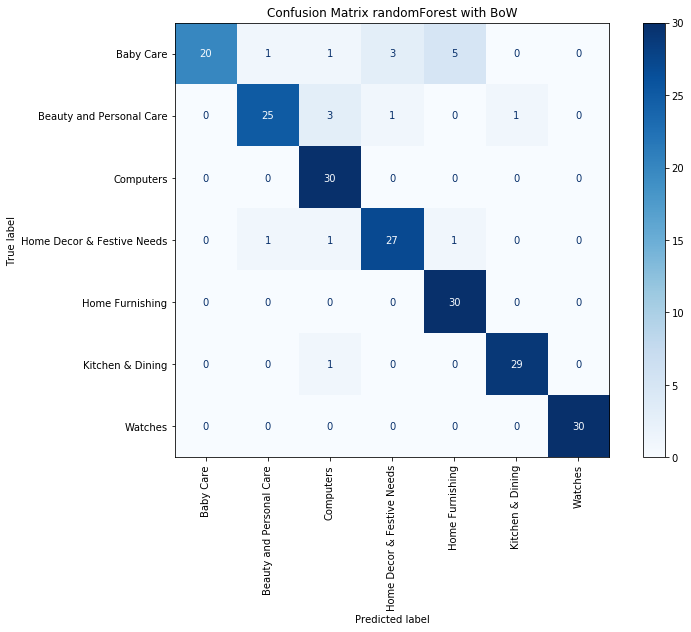

In [296]:
fig, ax = plt.subplots(figsize=(12, 8))

plot_confusion_matrix(bow_classifier,test.description,
                      test.category,
                      ax=ax,
                      xticks_rotation=90,
                      cmap='Blues')  

ax.set_title('Confusion Matrix randomForest with BoW')
plt.show()  

## TF-IDF

In [18]:
# Exact same pattern as BOW but with TFidfVectorizer from SKlearn

tfidf_vectorizer = TfidfVectorizer(encoding='utf-8',
                                   lowercase=True,
                                   tokenizer=LemmaTokenizer(),
                                   stop_words=english_sw)

tfidf = tfidf_vectorizer.fit_transform(train['description'])

In [19]:
tfidf

<840x4461 sparse matrix of type '<class 'numpy.float64'>'
	with 30562 stored elements in Compressed Sparse Row format>

In [159]:
tfidf_vectorizer.get_feature_names()

['0',
 '00',
 '000',
 '001',
 '0021',
 '004',
 '005',
 '006',
 '0083',
 '01',
 '011',
 '01727lpln',
 '01784bmly',
 '02',
 '03',
 '03918cmly',
 '04',
 '04615cmgy',
 '050',
 '052',
 '05712lmly',
 '05tg',
 '06',
 '063',
 '06362cmgy',
 '064',
 '069',
 '07',
 '07034lmli',
 '074',
 '08',
 '085',
 '09321cmgy',
 '099',
 '1',
 '10',
 '100',
 '1000',
 '1001',
 '10024982',
 '101',
 '1010',
 '1014tx',
 '1015',
 '1015nr',
 '1020el',
 '1033',
 '1038',
 '104',
 '1042',
 '1045',
 '1049',
 '105key',
 '107',
 '1071',
 '107750',
 '108',
 '1085',
 '10890',
 '1099',
 '109b0109',
 '10btsc2012gb',
 '11',
 '110',
 '1100',
 '11000026',
 '112',
 '1132',
 '1142301',
 '1143',
 '1149',
 '1150',
 '1153',
 '1170',
 '1183',
 '119',
 '1195',
 '1199',
 '11n',
 '11oz',
 '12',
 '120',
 '1200',
 '12011ppgw',
 '121',
 '1216',
 '122',
 '1234',
 '12399',
 '1240sg',
 '1241ea',
 '125',
 '125g',
 '129',
 '1290',
 '1295',
 '1299',
 '12v',
 '12x12',
 '12x18',
 '13',
 '130',
 '132',
 '1333',
 '13400',
 '1349',
 '1350',
 '137',
 '1

In [130]:
a = tfidf.todense()[0,:].tolist()
a
list_row0 = [i for i,v in enumerate(a[0]) if v>0 ]
list_values0 = [v for i,v in enumerate(a[0]) if v>0 ]
list_word0 = []
for val in list_row0:
    list_word0.append(tfidf_vectorizer.get_feature_names()[val])

In [136]:
view_tfidf = pd.DataFrame(list(zip(list_word0,list_values0)),columns=['word','value'])
view_tfidf.sort_values(by='value',ascending=False)

word     value
32            lamp  0.480430
30     handcrafted  0.277812
29           glass  0.255150
38          mosaic  0.230299
43           power  0.219067
6               35  0.212571
13            blue  0.195958
17            bulb  0.182188
51          unique  0.172204
49           table  0.161152
19              cm  0.138441
8             60hz  0.122185
16          buffet  0.122185
18            cfsl  0.122185
4             1x15  0.122185
5             240v  0.122185
24        eternity  0.122185
25  eternity001007  0.122185
2              110  0.115149
11        assembly  0.110158
1             1000  0.106285
22            desk  0.103122
37           model  0.100861
45     requirement  0.096086
12            base  0.094258
9               ac  0.091094
47          source  0.091094
36           metal  0.091094
35        material  0.089383
40          number  0.088986
44        required  0.088419
42         package  0.088014
46            sale  0.087823
20           color  0.087444
50            type  0.086513
7               50  0.082230
26         feature  0.081559
3               15  0.080576
0                1  0.079399
33             led  0.077023
34           light  0.070202
14            body  0.064057
27               g  0.063755
10      additional  0.061778
52          weight  0.061513
31          height  0.059528
53           width  0.057746
39            name  0.057123
23       dimension  0.051139
21         content  0.051139
41            pack  0.045613
15             box  0.041594
28         general  0.039850
48   specification  0.037003

In [137]:
train.description[0]

'Specifications of Eternity Handcrafted unique Mosaic Glass Table Lamp (35 cm, Blue) In The Box Sales Package 1 Table Lamp Number of Contents in Sales Package Pack of 1 General Type Buffet, Desk Color Blue Lamp Body Material Glass Lamp Base Material Metal Bulb Type 1x15 LED, CFSL ,Bulb Light Color Blue Assembly Required No Model Name Handcrafted unique Mosaic Glass Model Number Eternity001007 Power Features Power Requirement 110-240V, 50/60Hz Power Source Ac Additional Features Handcrafted\xa0lamps Dimensions Width 15 cm Height 35 cm Weight 1000 g'

### RandomForestClassifier

In [333]:
# GridSearchCV on pipeling with TfidfVectorizer + Randomforest 


parameters = {"tfidfvectorizer__stop_words":[english_sw,most_common_sw,least_common_sw,complete_sw], #Stop_words optimizing
              "tfidfvectorizer__tokenizer":[LemmaTokenizer(),StemmTokenizer()], #Stemm or lemma 
              "tfidfvectorizer__ngram_range":[(1,1),(1,2)], #See if looking also at Bigrams can be helpful
              "randomforestclassifier__n_estimators": [100,150,200],  #Number of tree to build
              "randomforestclassifier__max_depth": np.linspace(10, 110, num = 4),   # Max depth of the tree
              "randomforestclassifier__min_samples_leaf": [1,3,5],#min amount of sample to have both left and right to a node
              "randomforestclassifier__max_features":['auto', 'sqrt'] # additionnal source of random (max feature available 
                                                                     # when looking at feature for best split)
             } 

tfidf_rfr_pipe = make_pipeline(TfidfVectorizer(encoding='utf-8',
                                               lowercase=True),
                             RandomForestClassifier())

tfidf_rfr_grid = GridSearchCV(estimator = tfidf_rfr_pipe, 
                              param_grid = parameters,
                              scoring ='accuracy' ,
                              cv=5)

tfidf_rfr_grid.fit(train.description, train.category)

tfidf_classifier = tfidf_rfr_grid.best_estimator_


print('Validation Score (accuracy): ',tfidf_rfr_grid.best_score_)

print('\nBest Params: ',tfidf_rfr_grid.best_params_)

print('\nTest Score (accuracy): ',accuracy_score(test.category,tfidf_classifier.predict(test.description)))


       

Validation Score (accuracy):  0.936904761904762

Best Params:  {'randomforestclassifier__max_depth': 76.66666666666667, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 200, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__stop_words': {'are', 'll', "shouldn't", 'where', 'a', 'than', "don't", 'on', 'ma', 'guarante', 'shan', 'won', 'off', 'both', 'these', 'onc', 'i', "it's", 'doesn', 'her', 'my', 'against', 'abov', 'each', 'he', "won't", 'products', 've', 'has', 'ourselv', 'some', 'replac', 'ours', 'itself', 'again', 'should', 't', 'our', 'own', 'below', 'wasn', 'of', 'here', 'there', 'me', 'watch', 'their', 'all', 'themselv', "shan't", "isn't", 'mightn', 'ani', "that'll", 'does', 'under', 'while', 'specifications', 'as', 'such', 'needn', 'his', 'in', 'buy', "wasn't", 'an', 're', 'at', 'genuine', 'aren', 'any', 'y', 'didn', "didn't", 'shouldn', 'through', 'they', 'shipping', 'couldn', 'veri', 

In [334]:
scoring =['accuracy','recall_macro','precision_macro','f1_macro']

summary_tfidf = pd.DataFrame(index=['train','test'],columns=scoring)

for score in scoring:
    
    summary_tfidf.loc['train',score]=cross_val_score(tfidf_classifier,
                                                     train.description,
                                                     train.category,
                                                     scoring=score,
                                                     cv=5).mean()

    
summary_tfidf.loc['test','accuracy']=accuracy_score(test.category,tfidf_classifier.predict(test.description))
summary_tfidf.loc['test','recall_macro']=recall_score(test.category,tfidf_classifier.predict(test.description),average='macro')
summary_tfidf.loc['test','precision_macro']=precision_score(test.category,tfidf_classifier.predict(test.description),average='macro')
summary_tfidf.loc['test','f1_macro']=f1_score(test.category,tfidf_classifier.predict(test.description),average='macro')

summary_tfidf

accuracy recall_macro precision_macro  f1_macro
train  0.936905     0.934524        0.938275  0.934022
test   0.919048     0.919048        0.923733  0.917557

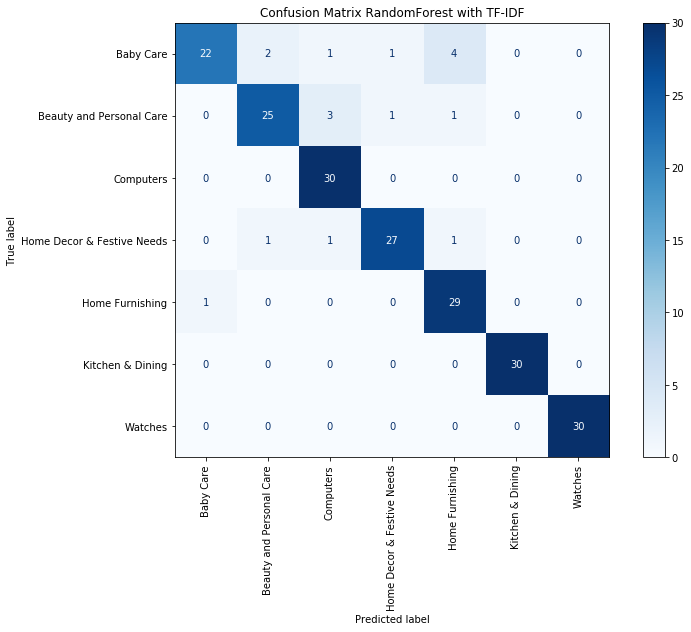

In [335]:
fig, ax = plt.subplots(figsize=(12, 8))

plot_confusion_matrix(tfidf_classifier,
                      test.description,
                      test.category,
                      ax=ax,
                      xticks_rotation=90,
                      cmap='Blues') 

ax.set_title('Confusion Matrix RandomForest with TF-IDF')
plt.show()  

# LDA and NMF

## LDA

In [21]:
bow_feature_names = bow_vectorizer.get_feature_names()

In [22]:
# Create LDA model based on the bag of words created in previous section
lda = LatentDirichletAllocation(
        n_components=train.category.nunique(), 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

# Fit on our bag of words
lda.fit(bow)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=7, random_state=0)

In [24]:
# Create function which will display the created topics and the n-associated top words 

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, bow_feature_names, no_top_words)



Topic 0:
warranty adapter laptop battery quality replacement product power charger vgn

Topic 1:
cm 1 feature specification color price pack baby r cotton

Topic 2:
r product free replacement cash delivery genuine buy day ship

Topic 3:
buy genuine cash delivery ship free r product flipkart com

Topic 4:
bowl sing scissor steel dessert dish shadow kitchen fork stainless

Topic 5:
mug coffee gift ceramic perfect make one tea love design

Topic 6:
usb light power lead portable flexible use phone otg android


In [25]:
lda_trans = lda.transform(bow)

In [45]:
a = pd.DataFrame(lda_trans)

In [46]:
a

0         1         2         3         4         5         6
0    0.001725  0.618707  0.001722  0.001722  0.001723  0.276581  0.097820
1    0.001643  0.990144  0.001642  0.001643  0.001642  0.001643  0.001643
2    0.002470  0.985195  0.002464  0.002475  0.002464  0.002465  0.002466
3    0.005318  0.005300  0.005292  0.968199  0.005292  0.005294  0.005305
4    0.007530  0.007552  0.007521  0.954785  0.007522  0.007562  0.007527
..        ...       ...       ...       ...       ...       ...       ...
835  0.007149  0.298204  0.007145  0.666018  0.007145  0.007193  0.007147
836  0.004930  0.004933  0.004927  0.567729  0.004927  0.407626  0.004928
837  0.004770  0.004797  0.004764  0.971376  0.004765  0.004764  0.004764
838  0.004611  0.272508  0.004609  0.704425  0.004609  0.004628  0.004610
839  0.003664  0.003665  0.003663  0.978018  0.003663  0.003663  0.003664

[840 rows x 7 columns]

### Differences between the base categories and the new found topics (sankey diagram)

In [47]:
a['category']=a.idxmax(axis=1)
a['real_categ']=train.category

In [51]:
a.real_categ.unique().tolist()

['Home Decor & Festive Needs',
 'Baby Care',
 'Beauty and Personal Care',
 'Home Furnishing',
 'Computers',
 'Watches',
 'Kitchen & Dining']

In [52]:
dict_categ = dict(zip(a.real_categ.unique().tolist(),range(7)))
dict_categ

{'Home Decor & Festive Needs': 0,
 'Baby Care': 1,
 'Beauty and Personal Care': 2,
 'Home Furnishing': 3,
 'Computers': 4,
 'Watches': 5,
 'Kitchen & Dining': 6}

In [53]:
a['real_categ_id']=a['real_categ'].map(dict_categ).fillna('Other')
a

0         1         2         3         4         5         6  \
0    0.001725  0.618707  0.001722  0.001722  0.001723  0.276581  0.097820   
1    0.001643  0.990144  0.001642  0.001643  0.001642  0.001643  0.001643   
2    0.002470  0.985195  0.002464  0.002475  0.002464  0.002465  0.002466   
3    0.005318  0.005300  0.005292  0.968199  0.005292  0.005294  0.005305   
4    0.007530  0.007552  0.007521  0.954785  0.007522  0.007562  0.007527   
..        ...       ...       ...       ...       ...       ...       ...   
835  0.007149  0.298204  0.007145  0.666018  0.007145  0.007193  0.007147   
836  0.004930  0.004933  0.004927  0.567729  0.004927  0.407626  0.004928   
837  0.004770  0.004797  0.004764  0.971376  0.004765  0.004764  0.004764   
838  0.004611  0.272508  0.004609  0.704425  0.004609  0.004628  0.004610   
839  0.003664  0.003665  0.003663  0.978018  0.003663  0.003663  0.003664   

     category                  real_categ  real_categ_id  
0           1  Home Decor & Festive Needs              0  
1           1                   Baby Care              1  
2           1    Beauty and Personal Care              2  
3           3                   Baby Care              1  
4           3             Home Furnishing              3  
..        ...                         ...            ...  
835         3                   Baby Care              1  
836         3            Kitchen & Dining              6  
837         3    Beauty and Personal Care              2  
838         3  Home Decor & Festive Needs              0  
839         3                     Watches              5  

[840 rows x 10 columns]

In [54]:
sankey_df = pd.DataFrame(index=a.index)
sankey_df['link'] = a['real_categ_id'].astype('str')+a['category'].astype('str')
sankey_df

link
0     01
1     11
2     21
3     13
4     33
..   ...
835   13
836   63
837   23
838   03
839   53

[840 rows x 1 columns]

In [56]:
# Get link/source/target dataframe to build the sankey diagram

sankey_df = pd.DataFrame(sankey_df['link'].value_counts().sort_index(ascending=True))
sankey_df['source']=sankey_df.index.str.slice(0, 1)
sankey_df['target']=sankey_df.index.str.slice(1,2)
sankey_df['source']=sankey_df['source'].astype('int64')
sankey_df['target']=sankey_df['target'].astype('int64')
sankey_df['target']+=7
sankey_df

link  source  target
01    45       0       8
03    54       0      10
04     1       0      11
05    15       0      12
06     5       0      13
11    93       1       8
13    26       1      10
15     1       1      12
21    32       2       8
23    81       2      10
24     1       2      11
26     6       2      13
31    57       3       8
33    59       3      10
35     1       3      12
36     3       3      13
40    22       4       7
41    12       4       8
43    62       4      10
46    24       4      13
51     7       5       8
53   110       5      10
55     3       5      12
60     1       6       7
61    45       6       8
63    38       6      10
64     6       6      11
65    29       6      12
66     1       6      13

In [69]:
labels = a.real_categ.unique().tolist() + list((range(7)))
for i in range(len(labels)):
    labels[i]=str(labels[i])
    
labels

['Home Decor & Festive Needs',
 'Baby Care',
 'Beauty and Personal Care',
 'Home Furnishing',
 'Computers',
 'Watches',
 'Kitchen & Dining',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6']

In [70]:
# Here is the construction of our sankey chart 
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels,
      color = "blue"
    ),
    link = dict(
      source = sankey_df.source , # indices correspond to labels, eg A1, A2, A2, B1, ...
      target = sankey_df.target,
      value = sankey_df.link
  ))])

fig.update_layout(title_text="Transferts from predicted clusters to new fitted clusters",
                  font_size=13,
                  width=1000,
                  height=700)
fig.show()

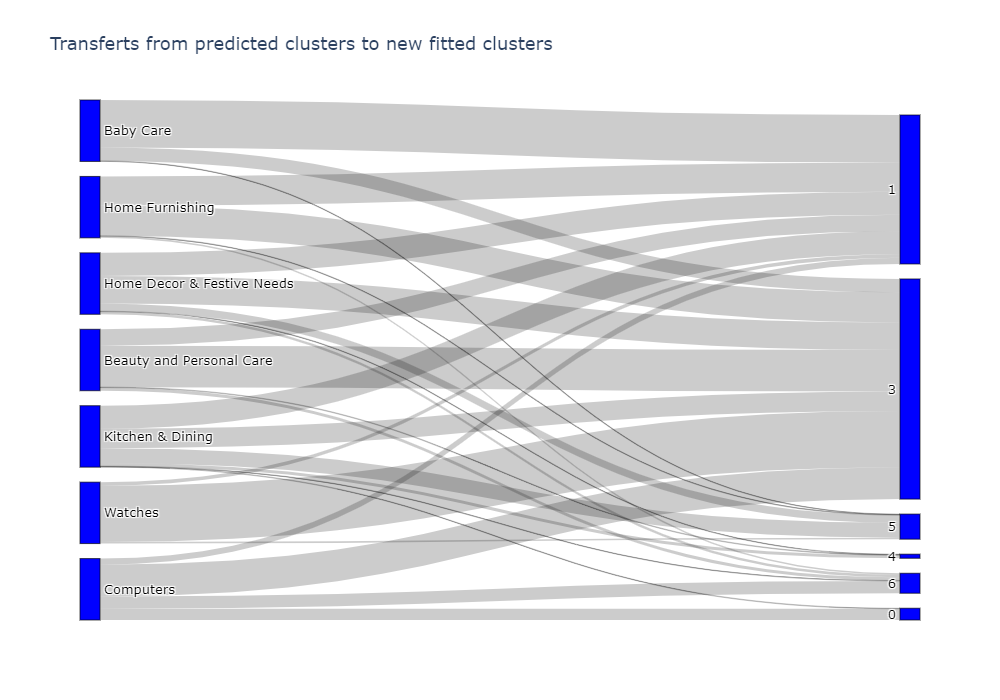

In [72]:
my_lda = pd.DataFrame(lda_trans)
my_lda

0         1         2         3         4         5         6
0    0.001725  0.618707  0.001722  0.001722  0.001723  0.276581  0.097820
1    0.001643  0.990144  0.001642  0.001643  0.001642  0.001643  0.001643
2    0.002470  0.985195  0.002464  0.002475  0.002464  0.002465  0.002466
3    0.005318  0.005300  0.005292  0.968199  0.005292  0.005294  0.005305
4    0.007530  0.007552  0.007521  0.954785  0.007522  0.007562  0.007527
..        ...       ...       ...       ...       ...       ...       ...
835  0.007149  0.298204  0.007145  0.666018  0.007145  0.007193  0.007147
836  0.004930  0.004933  0.004927  0.567729  0.004927  0.407626  0.004928
837  0.004770  0.004797  0.004764  0.971376  0.004765  0.004764  0.004764
838  0.004611  0.272508  0.004609  0.704425  0.004609  0.004628  0.004610
839  0.003664  0.003665  0.003663  0.978018  0.003663  0.003663  0.003664

[840 rows x 7 columns]

### Random Forest

In [74]:
parameters = {"n_estimators": [100,150,200],  #Number of tree to build
              "max_depth": np.linspace(10, 110, num = 4),   # Max depth of the tree
              "min_samples_leaf": [1,3,5],#min amount of sample to have both left and right to a node
              "max_features":['auto', 'sqrt'] # additionnal source of random (max feature available 
                                                                     # when looking at feature for best split)
             } 

# tfidf_rfr_pipe = make_pipeline(TfidfVectorizer(encoding='utf-8',
#                                              lowercase=True,
#                                              tokenizer=LemmaTokenizer()),
#                              RandomForestClassifier())

lda_rfr_grid = GridSearchCV(estimator = RandomForestClassifier(), 
                              param_grid = parameters,
                              scoring ='accuracy' ,
                              cv=5)

lda_rfr_grid.fit(my_lda, train.category)

lda_classifier =lda_rfr_grid.best_estimator_


print('Validation Score (accuracy): ',lda_rfr_grid.best_score_)

print('\nBest Params: ',lda_rfr_grid.best_params_)



Validation Score (accuracy):  0.6738095238095239

Best Params:  {'max_depth': 10.0, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200}


## NMF

In [77]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [80]:
# Create NMF model based on the tf-idf dataset created in previous section
nmf = NMF(n_components=train.category.nunique(),
          random_state=1,
          alpha=.1,
          l1_ratio=.5,
          init='nndsvd')


# Fitter sur les données
nmf.fit(tfidf)

NMF(alpha=0.1, init='nndsvd', l1_ratio=0.5, n_components=7, random_state=1)

In [81]:
no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)


Topic 0:
com flipkart genuine cash ship delivery buy free product guarantee

Topic 1:
rockmantra 5 mug ceramic porcelain permanent thrill stay start dishwasher

Topic 2:
baby girl detail fabric cotton dress sleeve boy neck shirt

Topic 3:
watch analog men woman discount india great dial maximum strap

Topic 4:
mug coffee ceramic perfect tea printland gift one love get

Topic 5:
cm showpiece cover cushion best design 5 1 inch pack

Topic 6:
laptop skin shape mouse warranty pad print 6 inch battery


In [82]:
nmf_trans = nmf.transform(tfidf)

In [83]:
my_nmf = pd.DataFrame(nmf_trans)

In [85]:
my_nmf

0         1         2         3         4         5         6
0    0.000000  0.000000  0.012608  0.000000  0.000000  0.113504  0.002861
1    0.000000  0.000000  0.225273  0.000000  0.000000  0.000000  0.000000
2    0.000000  0.000000  0.004264  0.003222  0.000000  0.008267  0.000000
3    0.043016  0.000000  0.000000  0.000010  0.000000  0.002402  0.000000
4    0.112547  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
..        ...       ...       ...       ...       ...       ...       ...
835  0.028747  0.000000  0.000000  0.007299  0.000000  0.000000  0.000000
836  0.062744  0.030902  0.000000  0.000000  0.149503  0.010903  0.000000
837  0.102116  0.005987  0.000000  0.000000  0.000000  0.000000  0.000000
838  0.036471  0.000000  0.000000  0.000000  0.000000  0.111063  0.000000
839  0.008186  0.000000  0.000000  0.203405  0.000000  0.000000  0.000000

[840 rows x 7 columns]

In [86]:
my_nmf['category']=my_nmf.idxmax(axis=1)
my_nmf['real_categ']=train.category

In [87]:
my_nmf.real_categ.unique().tolist()

['Home Decor & Festive Needs',
 'Baby Care',
 'Beauty and Personal Care',
 'Home Furnishing',
 'Computers',
 'Watches',
 'Kitchen & Dining']

In [88]:
dict_categ = dict(zip(my_nmf.real_categ.unique().tolist(),range(7)))
dict_categ

{'Home Decor & Festive Needs': 0,
 'Baby Care': 1,
 'Beauty and Personal Care': 2,
 'Home Furnishing': 3,
 'Computers': 4,
 'Watches': 5,
 'Kitchen & Dining': 6}

In [89]:
my_nmf['real_categ_id']=my_nmf['real_categ'].map(dict_categ).fillna('Other')
my_nmf

0         1         2         3         4         5         6  \
0    0.000000  0.000000  0.012608  0.000000  0.000000  0.113504  0.002861   
1    0.000000  0.000000  0.225273  0.000000  0.000000  0.000000  0.000000   
2    0.000000  0.000000  0.004264  0.003222  0.000000  0.008267  0.000000   
3    0.043016  0.000000  0.000000  0.000010  0.000000  0.002402  0.000000   
4    0.112547  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
835  0.028747  0.000000  0.000000  0.007299  0.000000  0.000000  0.000000   
836  0.062744  0.030902  0.000000  0.000000  0.149503  0.010903  0.000000   
837  0.102116  0.005987  0.000000  0.000000  0.000000  0.000000  0.000000   
838  0.036471  0.000000  0.000000  0.000000  0.000000  0.111063  0.000000   
839  0.008186  0.000000  0.000000  0.203405  0.000000  0.000000  0.000000   

     category                  real_categ  real_categ_id  
0           5  Home Decor & Festive Needs              0  
1           2                   Baby Care              1  
2           5    Beauty and Personal Care              2  
3           0                   Baby Care              1  
4           0             Home Furnishing              3  
..        ...                         ...            ...  
835         0                   Baby Care              1  
836         4            Kitchen & Dining              6  
837         0    Beauty and Personal Care              2  
838         5  Home Decor & Festive Needs              0  
839         3                     Watches              5  

[840 rows x 10 columns]

In [90]:
sankey_df = pd.DataFrame(index=my_nmf.index)
sankey_df['link'] = my_nmf['real_categ_id'].astype('str')+my_nmf['category'].astype('str')
sankey_df

link
0     05
1     12
2     25
3     10
4     30
..   ...
835   10
836   64
837   20
838   05
839   53

[840 rows x 1 columns]

In [91]:
sankey_df = pd.DataFrame(sankey_df['link'].value_counts().sort_index(ascending=True))
sankey_df['source']=sankey_df.index.str.slice(0, 1)
sankey_df['target']=sankey_df.index.str.slice(1,2)
sankey_df['source']=sankey_df['source'].astype('int64')
sankey_df['target']=sankey_df['target'].astype('int64')
sankey_df['target']+=7
sankey_df

link  source  target
00     9       0       7
01     1       0       8
05   106       0      12
06     4       0      13
10    27       1       7
11     1       1       8
12    77       1       9
14     2       1      11
15    10       1      12
16     3       1      13
20    85       2       7
21     2       2       8
22     5       2       9
23     1       2      10
25    16       2      12
26    11       2      13
30    62       3       7
31     2       3       8
32    12       3       9
35    40       3      12
36     4       3      13
40    59       4       7
45    11       4      12
46    50       4      13
53   119       5      10
55     1       5      12
60    25       6       7
61    31       6       8
62     1       6       9
64    42       6      11
65    21       6      12

In [92]:
labels = my_nmf.real_categ.unique().tolist() + list((range(7)))
for i in range(len(labels)):
    labels[i]=str(labels[i])
    
labels

['Home Decor & Festive Needs',
 'Baby Care',
 'Beauty and Personal Care',
 'Home Furnishing',
 'Computers',
 'Watches',
 'Kitchen & Dining',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6']

In [93]:
# Here is the construction of our sankey chart 
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels,
      color = "blue"
    ),
    link = dict(
      source = sankey_df.source , # indices correspond to labels, eg A1, A2, A2, B1, ...
      target = sankey_df.target,
      value = sankey_df.link
  ))])

fig.update_layout(title_text="Transferts from predicted clusters to new fitted clusters",
                  font_size=13,
                  width=1000,
                  height=700)
fig.show()

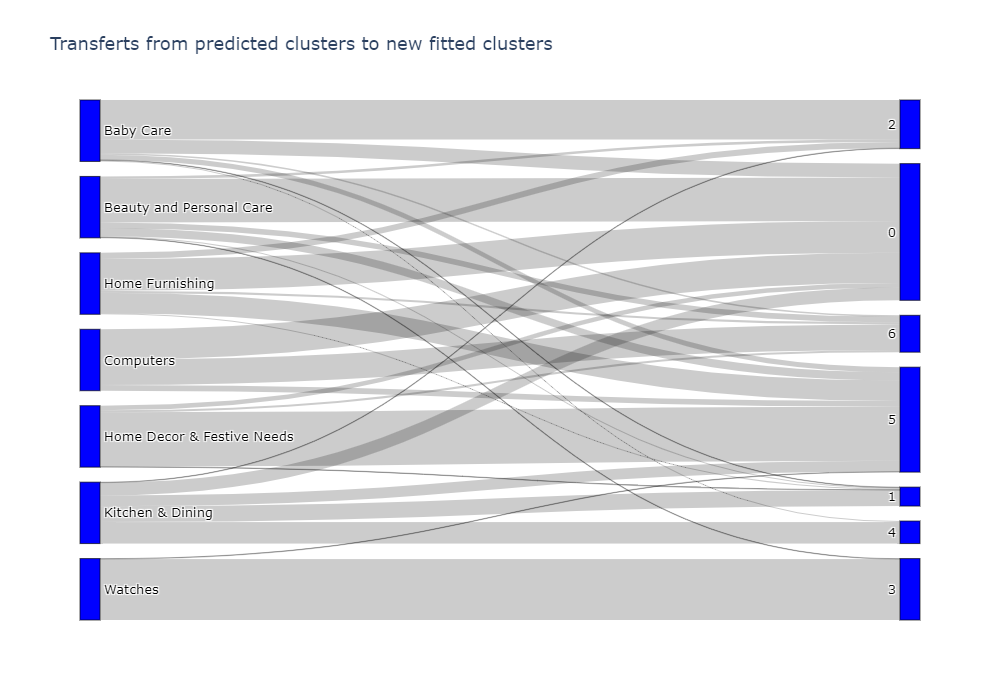

# Test Kmeans

## Distribution Overview function

Here the function will execute the following task : 
   * Plot the peercentage of product per cluster 
   * Show the distribution of each category within each cluster
   
   => This will help understanding the caracteristics of each cluster and if we are able to have a classification close enough from our baseline

Function parameters: 
   * data : dataset containing the descriptions
   * labels : list containing cluster labels
   
**The function return a summary dataframe that contains the occurence of each category in each cluster **

In [246]:
def observ_cluster(data,labels):
    
    view_clusters = pd.Series(labels)
    
    pivot = data.drop(columns=['description','image'])
    pivot['label']=labels
    pivot['count']=1
    pivot = pivot.groupby(by=['label','category']).count().unstack().fillna(0)
    pivot.columns=pivot.columns.droplevel()
    
    pivot.plot(kind='bar',stacked=True,legend=True,figsize=(12,8),title='Category repartition per cluster')

    row_data=data.shape[0]

    if view_clusters.nunique() > 15:
        font = 8 
    else : 
        font = 12

    for index, value in enumerate(view_clusters.value_counts().sort_index(ascending=True)):
        percentage = np.around(value/row_data*100,1)   
        plt.text(index-0.25, value+2, str(percentage)+' %',fontsize=font)

    plt.xlabel('Cluster ID', fontsize=12)
    plt.ylabel('Number of sample', fontsize=12)
    plt.show()    
    
    return pivot



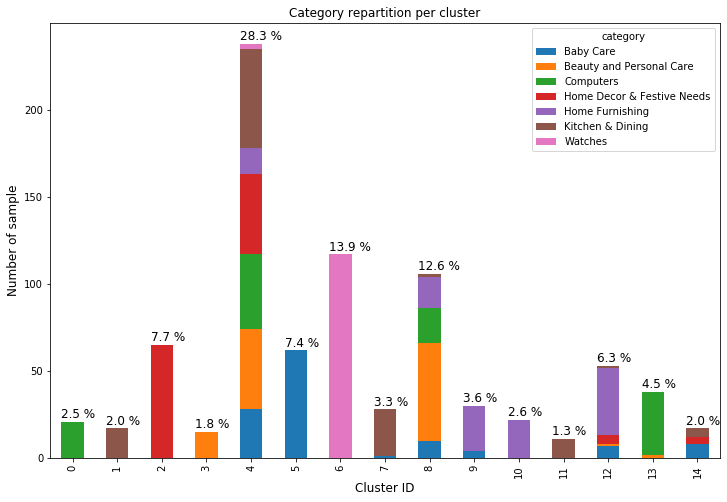

category  Baby Care  Beauty and Personal Care  Computers  \
label                                                      
0               0.0                       0.0       21.0   
1               0.0                       0.0        0.0   
2               0.0                       0.0        0.0   
3               0.0                      15.0        0.0   
4              28.0                      46.0       43.0   
5              62.0                       0.0        0.0   
6               0.0                       0.0        0.0   
7               1.0                       0.0        0.0   
8              10.0                      56.0       20.0   
9               4.0                       0.0        0.0   
10              0.0                       0.0        0.0   
11              0.0                       0.0        0.0   
12              7.0                       1.0        0.0   
13              0.0                       2.0       36.0   
14              8.0                       0.0        0.0   

category  Home Decor & Festive Needs  Home Furnishing  Kitchen & Dining  \
label                                                                     
0                                0.0              0.0               0.0   
1                                0.0              0.0              17.0   
2                               65.0              0.0               0.0   
3                                0.0              0.0               0.0   
4                               46.0             15.0              57.0   
5                                0.0              0.0               0.0   
6                                0.0              0.0               0.0   
7                                0.0              0.0              27.0   
8                                0.0             18.0               2.0   
9                                0.0             26.0               0.0   
10                               0.0             22.0               0.0   
11                               0.0              0.0              11.0   
12                               5.0             39.0               1.0   
13                               0.0              0.0               0.0   
14                               4.0              0.0               5.0   

category  Watches  
label              
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             3.0  
5             0.0  
6           117.0  
7             0.0  
8             0.0  
9             0.0  
10            0.0  
11            0.0  
12            0.0  
13            0.0  
14            0.0

In [247]:
observ_cluster(train,cls15.labels_)

## Most common words of each cluster function

Create a function showing the n-topwords of each cluster

In [171]:
def clusters_common_words(data,cluster_label,data_words,nb_common_words):
    
    a =pd.DataFrame(data, columns=data_words)
    a['label']=cluster_label
    b= a.groupby(by='label').sum()
    c= pd.DataFrame(index=range(nb_common_words))
    for i in range(b.shape[0]):
        c['Cluster {}'.format(b.index[i])]=b.iloc[i,:].sort_values(ascending=False).head(nb_common_words).index.tolist()
    return c


In [172]:
clusters_common_words(dense_tfidf,cls7.labels_,tfidf_vectorizer.get_feature_names(),10)

Cluster 0 Cluster 1    Cluster 2 Cluster 3 Cluster 4 Cluster 5 Cluster 6
0         mug       com    showpiece      baby        cm       usb     watch
1     ceramic  flipkart         best    detail         1     light    analog
2      coffee   genuine           cm      girl      pack     power       men
3     perfect      cash       online    fabric      inch      lead     woman
4        gift      ship           30     dress      skin   adapter  discount
5  rockmantra  delivery    guarantee    cotton       box    laptop     india
6        love      free  replacement    sleeve    design   battery     great
7         one       buy          day      neck     print  warranty      dial
8           5   product        price       boy     color  portable       com
9      design         r         cash     shirt  material  flexible  flipkart

## Evaluate which number of clusters gives best results

We will try to overview the performance of clusters between 2 and 30 by ploting the silhouette scores and the relative standard deviation. The idea is to stop which number of cluster give the best shape of cluster

In [174]:
dense_tfidf= tfidf.todense()


In [182]:
range_clust = range(2,30)
summary_silhouettes=pd.DataFrame(index=range_clust)
summary_RSD=pd.DataFrame(index=range_clust)

silhouettes=[]
RSD = []
# Create a loop of 5 iteration (to observ stability)
for k in range(1,6):
    # Create a loop of to observ the result for each number of clusters chosen
    for i in range(2,30):
        cls= cluster.KMeans(n_clusters=i)
        cls.fit(dense_tfidf)

        silh= silhouette_score(dense_tfidf,cls.labels_)
        silhouettes.append(silh)

        sigma = np.std(pd.Series(cls.labels_).value_counts().values)
        mu = np.mean(pd.Series(cls.labels_).value_counts().values)
        RSD.append(np.around(np.abs(sigma/mu),2))

    summary_silhouettes['sil{}'.format(k)]=silhouettes
    summary_RSD['RSD{}'.format(k)]=RSD
    silhouettes=[]
    RSD = []


summary_silhouettes

sil1      sil2      sil3      sil4      sil5
2   0.029564  0.029681  0.029564  0.029681  0.029564
3   0.039004  0.037976  0.037976  0.037976  0.037976
4   0.027644  0.036399  0.036777  0.036777  0.036399
5   0.035632  0.039969  0.041467  0.040037  0.039276
6   0.045232  0.037659  0.042608  0.037825  0.048725
7   0.048495  0.047576  0.040423  0.035249  0.047919
8   0.055159  0.043760  0.039276  0.041898  0.052858
9   0.050316  0.049178  0.046708  0.045746  0.057995
10  0.044980  0.061160  0.049274  0.051115  0.056144
11  0.058688  0.055850  0.054617  0.050256  0.051848
12  0.055516  0.057570  0.052561  0.055390  0.052796
13  0.056700  0.061667  0.053956  0.045110  0.055421
14  0.063591  0.058904  0.064505  0.057136  0.053721
15  0.058769  0.056778  0.066445  0.054117  0.058502
16  0.066625  0.068385  0.067609  0.059104  0.069848
17  0.054866  0.055001  0.058964  0.061145  0.063685
18  0.063810  0.066367  0.059968  0.064526  0.059893
19  0.055688  0.063473  0.052032  0.063825  0.060924
20  0.065627  0.051640  0.071012  0.064917  0.064782
21  0.068275  0.062633  0.065991  0.069919  0.069843
22  0.061470  0.067748  0.071140  0.070514  0.075289
23  0.074135  0.067146  0.068589  0.065120  0.072918
24  0.064118  0.064541  0.068156  0.065060  0.067343
25  0.075600  0.063406  0.066510  0.078411  0.068896
26  0.069841  0.071356  0.077660  0.061848  0.069670
27  0.063155  0.076057  0.079700  0.066369  0.069658
28  0.079337  0.078737  0.087067  0.077978  0.075706
29  0.078905  0.084108  0.074192  0.079515  0.078852

In [183]:
summary_RSD

RSD1  RSD2  RSD3  RSD4  RSD5
2   0.04  0.05  0.04  0.05  0.04
3   0.61  0.58  0.58  0.58  0.58
4   0.65  0.63  0.60  0.60  0.63
5   0.59  0.64  0.67  0.76  0.61
6   0.57  0.75  0.54  0.74  0.86
7   1.00  0.58  0.71  0.65  0.62
8   0.67  0.60  0.69  0.57  0.97
9   0.87  1.04  0.78  0.71  0.71
10  0.71  0.79  0.78  0.86  1.01
11  0.83  0.97  0.80  0.88  0.84
12  0.77  0.87  0.85  1.07  0.94
13  0.72  0.91  0.90  0.97  0.59
14  1.09  0.89  0.83  1.04  0.63
15  0.97  0.76  1.01  0.85  0.95
16  1.08  0.95  0.86  0.81  0.94
17  0.84  0.70  1.08  1.00  0.82
18  0.90  1.03  0.73  0.82  0.98
19  0.84  0.75  0.75  0.78  0.81
20  0.90  0.95  1.26  1.00  0.81
21  1.08  0.81  0.97  1.03  1.02
22  0.85  0.98  0.78  0.86  0.90
23  1.12  0.95  0.93  0.93  1.10
24  0.81  0.93  1.01  0.70  1.04
25  1.02  0.88  0.89  0.86  0.98
26  0.80  0.86  0.90  0.81  0.86
27  0.85  0.74  0.93  0.99  0.92
28  1.12  0.85  0.93  0.85  1.00
29  0.71  1.09  0.97  0.98  0.88

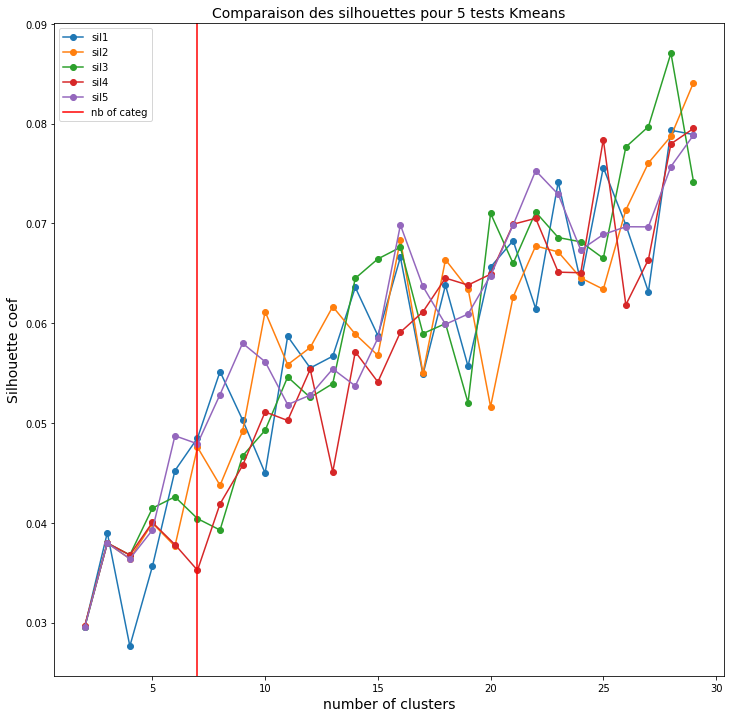

In [184]:
# Plot the result obtained above 
plt.figure(figsize=[12,12])
for col in summary_silhouettes.columns:
    plt.plot(range(2,30),summary_silhouettes[col],marker='o',label=col)
plt.title('Comparaison des silhouettes pour 5 tests Kmeans',fontsize=14)
plt.axvline(x=7,color='red',label='nb of categ')
plt.xlabel('number of clusters',fontsize=14)
plt.ylabel('Silhouette coef',fontsize=14)
plt.legend()

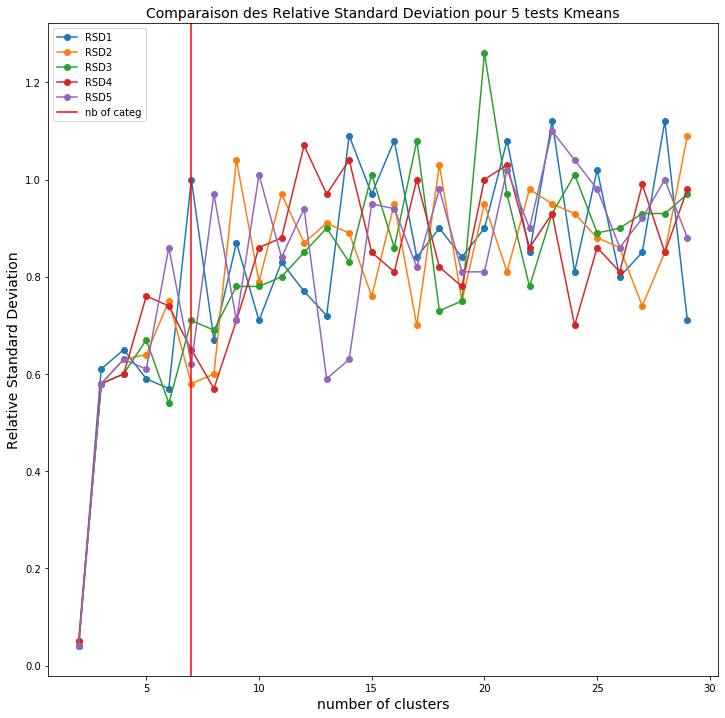

In [185]:
# Plot the result obtained above 
plt.figure(figsize=[12,12])
for col in summary_RSD.columns:
    plt.plot(range(2,30),summary_RSD[col],marker='o',label=col)
plt.title('Comparaison des Relative Standard Deviation pour 5 tests Kmeans',fontsize=14)
plt.axvline(x=7,color='red',label='nb of categ')
plt.xlabel('number of clusters',fontsize=14)
plt.ylabel('Relative Standard Deviation',fontsize=14)
plt.legend()

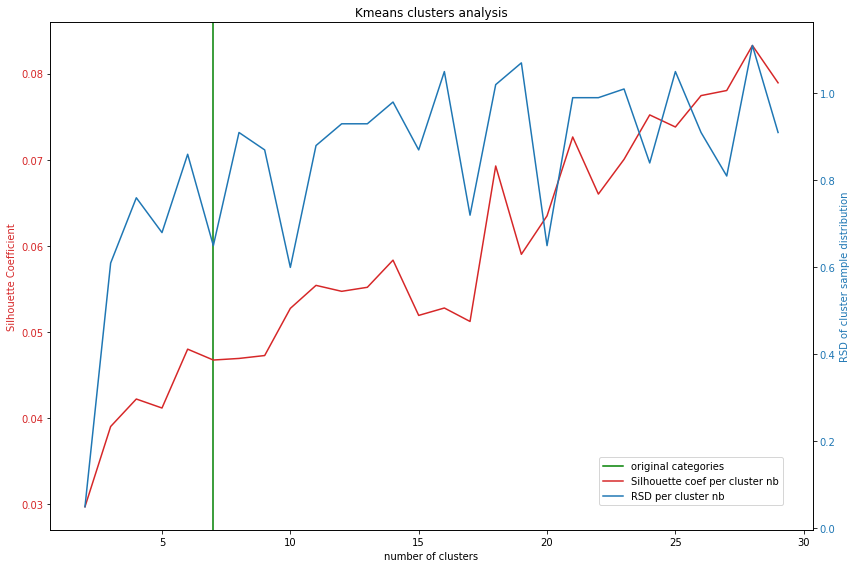

In [110]:
fig, ax1 = plt.subplots(figsize=(12,8))

plt.title('Kmeans clusters analysis')
plt.axvline(x=7,color='green',label='original categories')
color = 'tab:red'
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('Silhouette Coefficient', color=color)
ax1.plot(summary_silhouettes.index, summary_silhouettes.sil, color=color, label = 'Silhouette coef per cluster nb')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('RSD of cluster sample distribution', color=color)  # we already handled the x-label with ax1
ax2.plot(summary_silhouettes.index, summary_silhouettes.RSD, color=color,label = 'RSD per cluster nb')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(loc=8,bbox_to_anchor=(0.80,0.1, 0, 0))
plt.show()

In [249]:
pca =PCA(n_components=2)
pca.fit(dense_tfidf)
print(pca.explained_variance_ratio_.cumsum())
dense_tfidf_trans = pca.transform(dense_tfidf)

[0.03673682 0.06124505]


In [248]:
tsne = TSNE(n_components=2)
dense_tfidf_TSNE = tsne.fit_transform(dense_tfidf.copy())

## Kmeans

We will evaluate Kmeans results for 3/7/15 and 28 cluster with showing a TSNE view and also using our analysis functions created in previous sections

### Kmeans - 3 Clusters

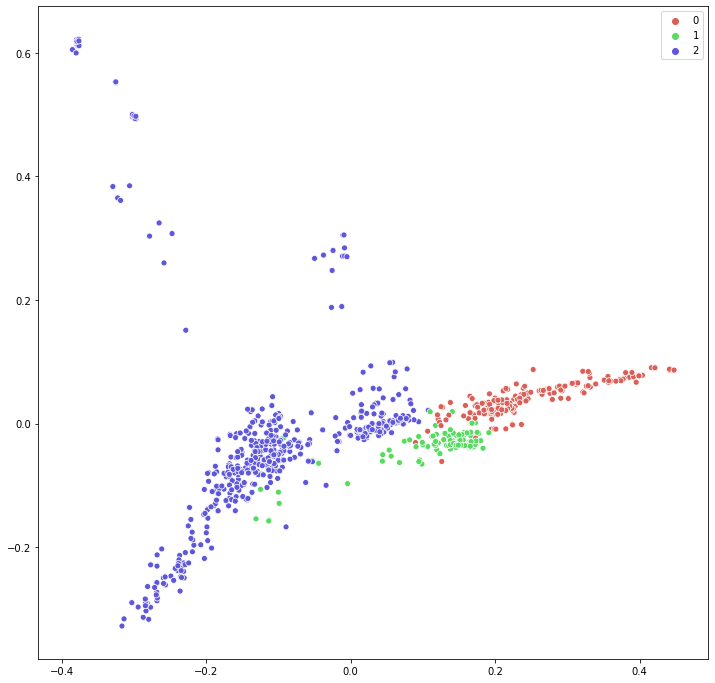

In [263]:
fig = plt.figure(figsize=[12,12])

cls3= cluster.KMeans(n_clusters=3)
cls3.fit(dense_tfidf)
sns.scatterplot(dense_tfidf_trans[:,0 ],
                dense_tfidf_trans[:,1],
                hue=cls3.labels_,
                legend='full',
                palette=sns.color_palette("hls", 3))

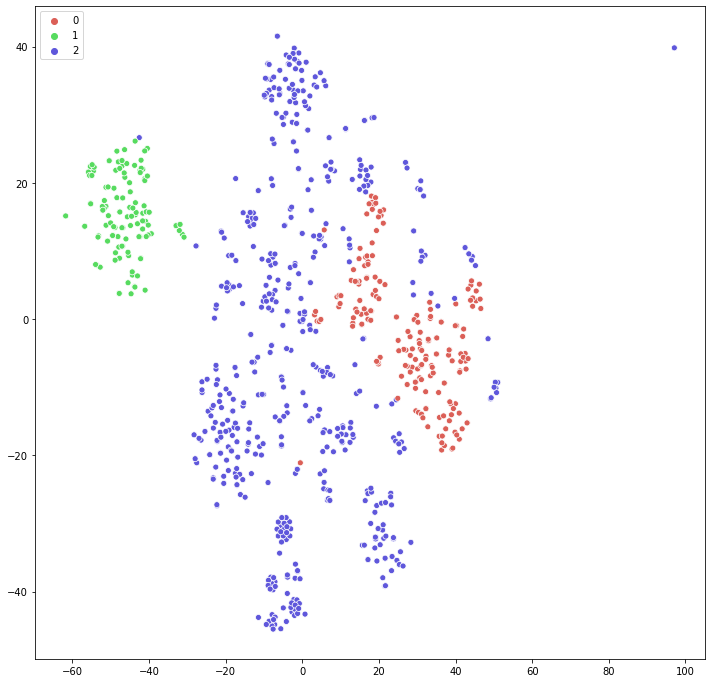

In [264]:
fig = plt.figure(figsize=[12,12])
sns.scatterplot(dense_tfidf_TSNE[:,0 ],
                dense_tfidf_TSNE[:,1],
                hue=cls3.labels_,
                legend='full',
                palette=sns.color_palette("hls",3))
plt.legend()

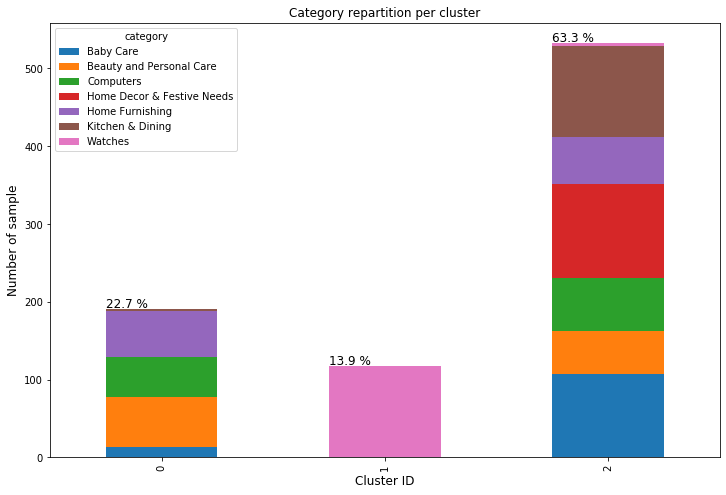

category  Baby Care  Beauty and Personal Care  Computers  \
label                                                      
0              13.0                      64.0       52.0   
1               0.0                       0.0        0.0   
2             107.0                      56.0       68.0   

category  Home Decor & Festive Needs  Home Furnishing  Kitchen & Dining  \
label                                                                     
0                                0.0             59.0               3.0   
1                                0.0              0.0               0.0   
2                              120.0             61.0             117.0   

category  Watches  
label              
0             0.0  
1           117.0  
2             3.0

In [265]:
observ_cluster(train,cls3.labels_)

In [266]:
clusters_common_words(dense_tfidf,cls3.labels_,tfidf_vectorizer.get_feature_names(),10)

Cluster 0 Cluster 1  Cluster 2
0       com     watch         cm
1  flipkart    analog        mug
2   genuine       men       baby
3      cash     woman          1
4      ship  discount      price
5  delivery     india  showpiece
6      free     great       best
7       buy      dial          5
8   product       com     design
9         r  flipkart     detail

### Kmeans - 7 Clusters

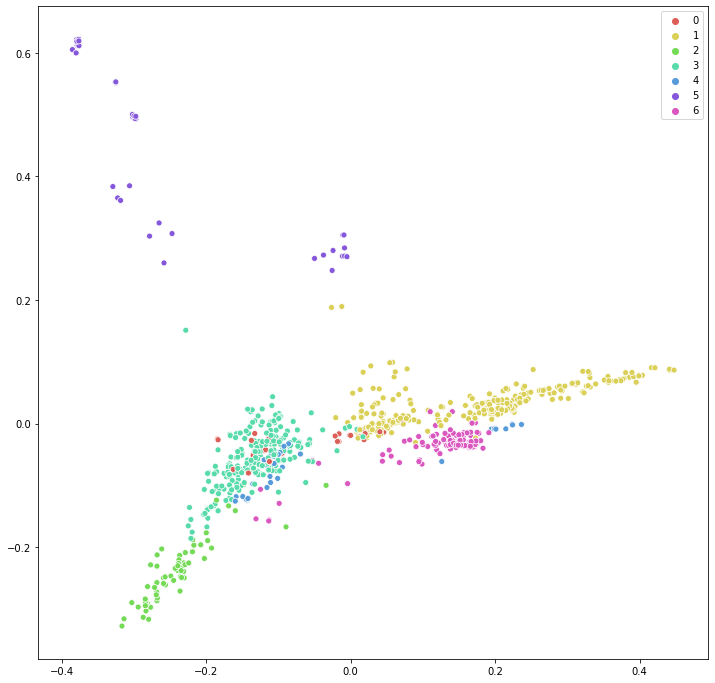

In [250]:
fig = plt.figure(figsize=[12,12])

cls7= cluster.KMeans(n_clusters=7)
cls7.fit(dense_tfidf)
sns.scatterplot(dense_tfidf_trans[:,0 ],
                dense_tfidf_trans[:,1],
                hue=cls7.labels_,
                legend='full',
                palette=sns.color_palette("hls", 7))

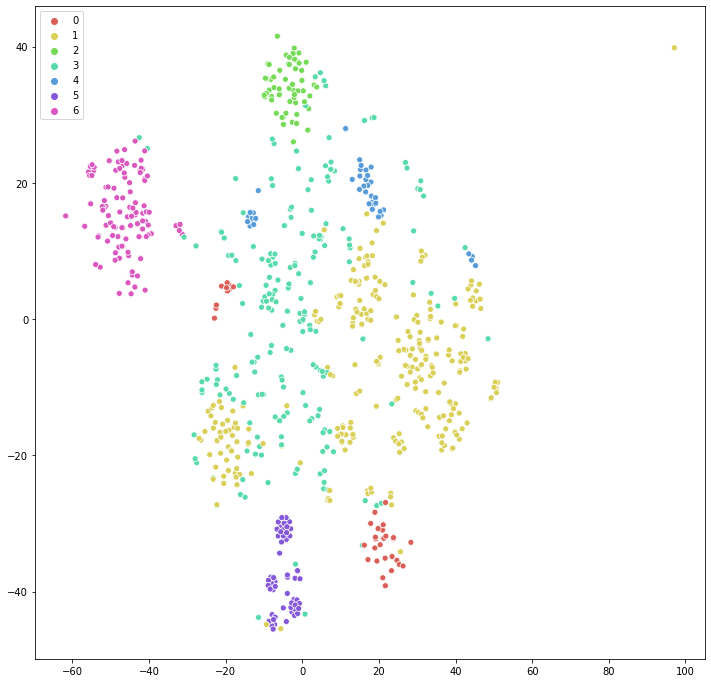

In [254]:
fig = plt.figure(figsize=[12,12])
sns.scatterplot(dense_tfidf_TSNE[:,0 ],
                dense_tfidf_TSNE[:,1],
                hue=cls7.labels_,
                legend='full',
                palette=sns.color_palette("hls",7))
plt.legend()

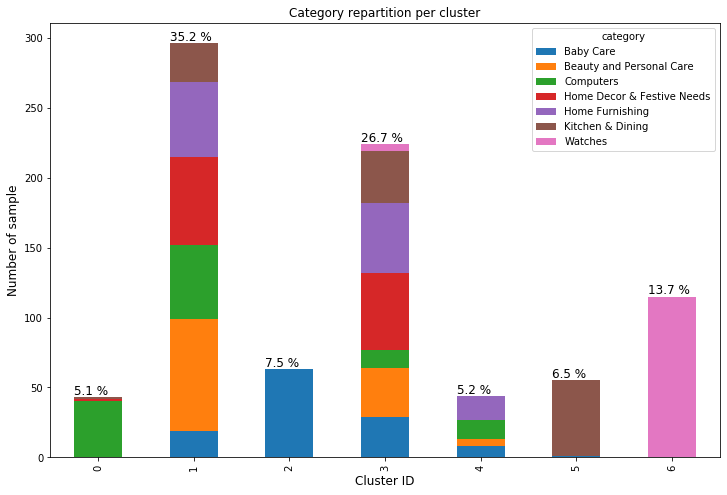

category  Baby Care  Beauty and Personal Care  Computers  \
label                                                      
0               0.0                       0.0       40.0   
1              19.0                      80.0       53.0   
2              63.0                       0.0        0.0   
3              29.0                      35.0       13.0   
4               8.0                       5.0       14.0   
5               1.0                       0.0        0.0   
6               0.0                       0.0        0.0   

category  Home Decor & Festive Needs  Home Furnishing  Kitchen & Dining  \
label                                                                     
0                                2.0              0.0               1.0   
1                               63.0             53.0              28.0   
2                                0.0              0.0               0.0   
3                               55.0             50.0              37.0   
4                                0.0             17.0               0.0   
5                                0.0              0.0              54.0   
6                                0.0              0.0               0.0   

category  Watches  
label              
0             0.0  
1             0.0  
2             0.0  
3             5.0  
4             0.0  
5             0.0  
6           115.0

In [252]:
observ_cluster(train,cls7.labels_)

In [256]:
clusters_common_words(dense_tfidf,cls7.labels_,tfidf_vectorizer.get_feature_names(),10)

Cluster 0 Cluster 1 Cluster 2 Cluster 3 Cluster 4   Cluster 5 Cluster 6
0       usb       com      baby        cm     towel         mug     watch
1     light  flipkart    detail         1      skin     ceramic    analog
2     power      cash      girl      pack      bath      coffee       men
3      lead   genuine    fabric       box    cotton     perfect     woman
4   adapter      ship     dress    design    laptop        gift  discount
5  warranty  delivery    cotton     color   battery  rockmantra     india
6  portable      free    sleeve  material       set        love     great
7  flexible       buy      neck   feature      soft         one       com
8    laptop   product       boy      inch     mouse           5      dial
9   charger        30     shirt     cover     print      design  flipkart

#### compare categ against clusters

In [133]:
dict_categ

{'Home Decor & Festive Needs': 0,
 'Baby Care': 1,
 'Beauty and Personal Care': 2,
 'Home Furnishing': 3,
 'Computers': 4,
 'Watches': 5,
 'Kitchen & Dining': 6}

In [135]:
a = train.reindex(columns=['category'])
a.rename(columns = {'category':'real_categ'}, inplace = True)
a['real_categ_id']=a['real_categ'].map(dict_categ).fillna('Other')
a['category']=cls7.labels_

In [136]:
a

real_categ  real_categ_id  category
0    Home Decor & Festive Needs              0         0
1                     Baby Care              1         2
2      Beauty and Personal Care              2         0
3                     Baby Care              1         1
4               Home Furnishing              3         3
..                          ...            ...       ...
835                   Baby Care              1         0
836            Kitchen & Dining              6         6
837    Beauty and Personal Care              2         1
838  Home Decor & Festive Needs              0         1
839                     Watches              5         5

[840 rows x 3 columns]

In [137]:
sankey_df = pd.DataFrame(index=a.index)
sankey_df['link'] = a['real_categ_id'].astype('str')+a['category'].astype('str')
sankey_df

link
0     00
1     12
2     20
3     11
4     33
..   ...
835   10
836   66
837   21
838   01
839   55

[840 rows x 1 columns]

In [138]:
sankey_df = pd.DataFrame(sankey_df['link'].value_counts().sort_index(ascending=True))
sankey_df['source']=sankey_df.index.str.slice(0, 1)
sankey_df['target']=sankey_df.index.str.slice(1,2)
sankey_df['source']=sankey_df['source'].astype('int64')
sankey_df['target']=sankey_df['target'].astype('int64')
sankey_df['target']+=7
sankey_df

link  source  target
00    53       0       7
01    63       0       8
04     4       0      11
10    25       1       7
11    21       1       8
12    59       1       9
13     3       1      10
14    11       1      11
16     1       1      13
20    36       2       7
21    79       2       8
24     5       2      11
30    14       3       7
31    25       3       8
33    34       3      10
34    47       3      11
40    67       4       7
41    53       4       8
50     3       5       7
55   117       5      12
60    39       6       7
61    27       6       8
66    54       6      13

In [139]:
labels = a.real_categ.unique().tolist() + list((range(7)))
for i in range(len(labels)):
    labels[i]=str(labels[i])
    
labels

['Home Decor & Festive Needs',
 'Baby Care',
 'Beauty and Personal Care',
 'Home Furnishing',
 'Computers',
 'Watches',
 'Kitchen & Dining',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6']

In [140]:
# Here is the construction of our sankey chart 
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels,
      color = "blue"
    ),
    link = dict(
      source = sankey_df.source , # indices correspond to labels, eg A1, A2, A2, B1, ...
      target = sankey_df.target,
      value = sankey_df.link
  ))])

fig.update_layout(title_text="Transferts from predicted clusters to new fitted clusters",
                  font_size=13,
                  width=1000,
                  height=700)
fig.show()

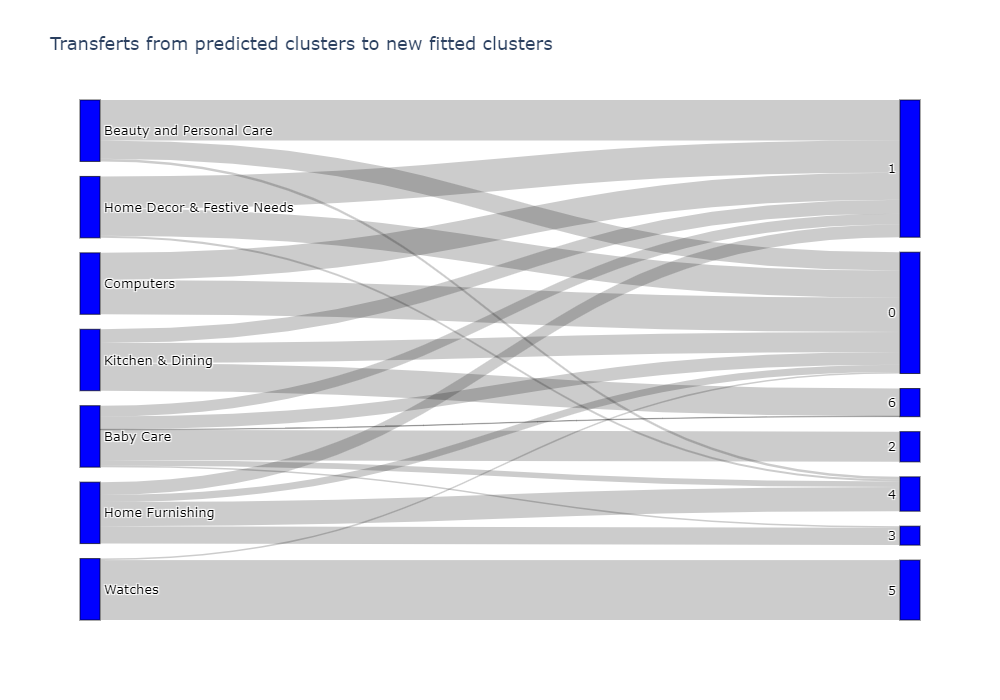

### Kmeans - 15 Clusters

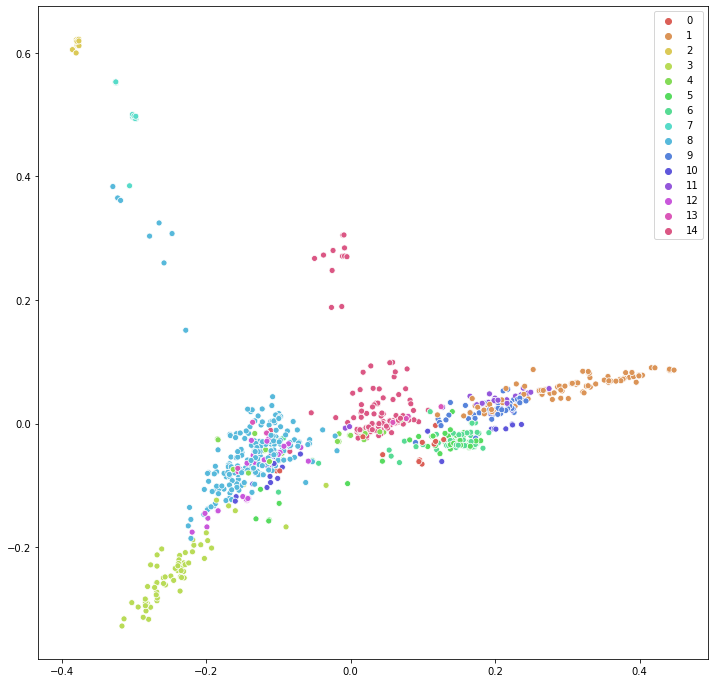

In [267]:
fig = plt.figure(figsize=[12,12])

cls15= cluster.KMeans(n_clusters=15)
cls15.fit(dense_tfidf)
sns.scatterplot(dense_tfidf_trans[:,0 ],
                dense_tfidf_trans[:,1],
                hue=cls15.labels_,
                legend='full',
                palette=sns.color_palette("hls", 15))

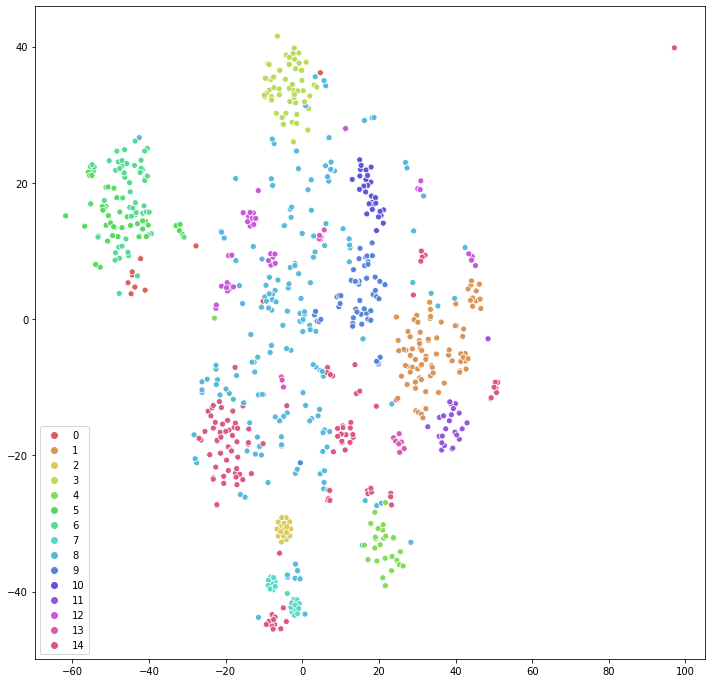

In [268]:
fig = plt.figure(figsize=[12,12])
sns.scatterplot(dense_tfidf_TSNE[:,0 ],
                dense_tfidf_TSNE[:,1],
                hue=cls15.labels_,
                legend='full',
                palette=sns.color_palette("hls",15))
plt.legend()

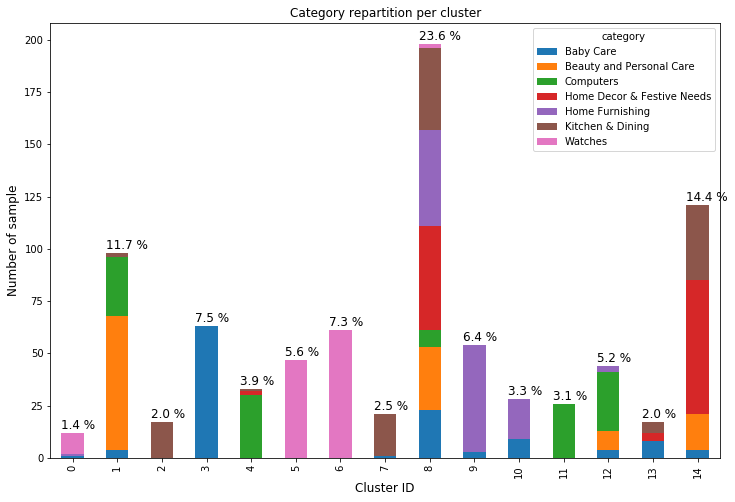

category  Baby Care  Beauty and Personal Care  Computers  \
label                                                      
0               1.0                       0.0        0.0   
1               4.0                      64.0       28.0   
2               0.0                       0.0        0.0   
3              63.0                       0.0        0.0   
4               0.0                       0.0       30.0   
5               0.0                       0.0        0.0   
6               0.0                       0.0        0.0   
7               1.0                       0.0        0.0   
8              23.0                      30.0        8.0   
9               3.0                       0.0        0.0   
10              9.0                       0.0        0.0   
11              0.0                       0.0       26.0   
12              4.0                       9.0       28.0   
13              8.0                       0.0        0.0   
14              4.0                      17.0        0.0   

category  Home Decor & Festive Needs  Home Furnishing  Kitchen & Dining  \
label                                                                     
0                                0.0              1.0               0.0   
1                                0.0              0.0               2.0   
2                                0.0              0.0              17.0   
3                                0.0              0.0               0.0   
4                                2.0              0.0               1.0   
5                                0.0              0.0               0.0   
6                                0.0              0.0               0.0   
7                                0.0              0.0              20.0   
8                               50.0             46.0              39.0   
9                                0.0             51.0               0.0   
10                               0.0             19.0               0.0   
11                               0.0              0.0               0.0   
12                               0.0              3.0               0.0   
13                               4.0              0.0               5.0   
14                              64.0              0.0              36.0   

category  Watches  
label              
0            10.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
5            47.0  
6            61.0  
7             0.0  
8             2.0  
9             0.0  
10            0.0  
11            0.0  
12            0.0  
13            0.0  
14            0.0

In [269]:
observ_cluster(train,cls15.labels_)

In [270]:
clusters_common_words(dense_tfidf,cls15.labels_,tfidf_vectorizer.get_feature_names(),10)

Cluster 0    Cluster 1   Cluster 2 Cluster 3 Cluster 4 Cluster 5 Cluster 6  \
0   digital          com  rockmantra      baby       usb     woman     watch   
1     watch     flipkart           5    detail     light    analog       men   
2       boy        combo         mug      girl      lead     watch    analog   
3     fiber           30     ceramic    fabric     power  discount  discount   
4     india    guarantee   permanent     dress  portable      dial     india   
5      girl  replacement   porcelain    cotton  flexible     india     great   
6  discount          set      thrill    sleeve       hub     great       com   
7     great          day        stay      neck      port     strap  flipkart   
8    online      genuine       start       boy      bank       com    online   
9      dial         cash         yet     shirt       fan  flipkart    sonata   

   Cluster 7 Cluster 8 Cluster 9 Cluster 10   Cluster 11 Cluster 12  \
0        mug        cm       com      towel       router     laptop   
1     coffee         1  flipkart       bath     wireless       skin   
2    perfect      pack   genuine     cotton          com   warranty   
3        tea       box      cash        com     flipkart    adapter   
4       gift    design      ship   flipkart    guarantee      sheet   
5  printland  material       buy        set           30    battery   
6    ceramic     color  delivery       free  replacement   bedsheet   
7        one   feature    single    genuine          day      print   
8        get     model  abstract       cash      genuine      mouse   
9       love    number      free       ship         cash      cover   

   Cluster 13   Cluster 14  
0     sticker    showpiece  
1       vinyl         best  
2      bottle           cm  
3     nutcase       online  
4      medium           30  
5        wall    guarantee  
6  wallmantra  replacement  
7        wrap          day  
8    adhesive        price  
9       large      genuine

### Kmeans - 28 Clusters

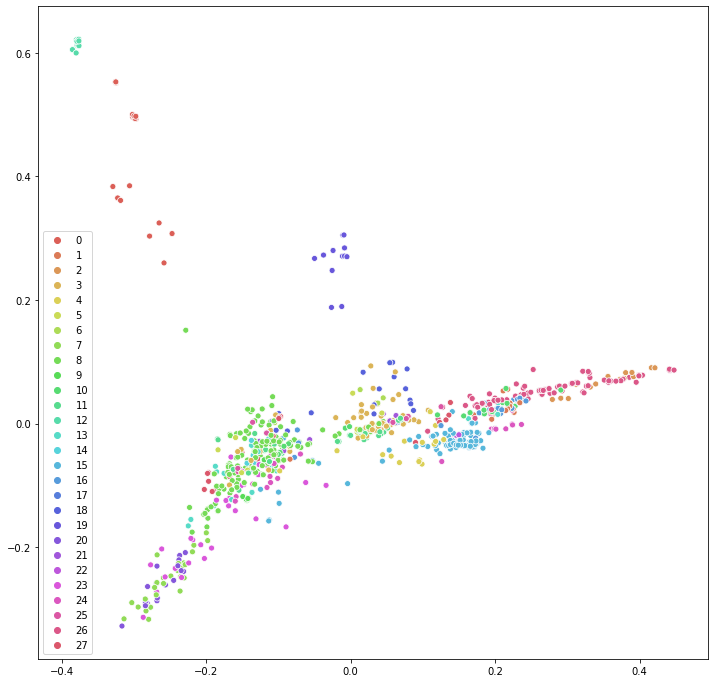

In [271]:
fig = plt.figure(figsize=[12,12])

cls28= cluster.KMeans(n_clusters=28)
cls28.fit(dense_tfidf)
sns.scatterplot(dense_tfidf_trans[:,0 ],
                dense_tfidf_trans[:,1],
                hue=cls28.labels_,
                legend='full',
                palette=sns.color_palette("hls", 28))

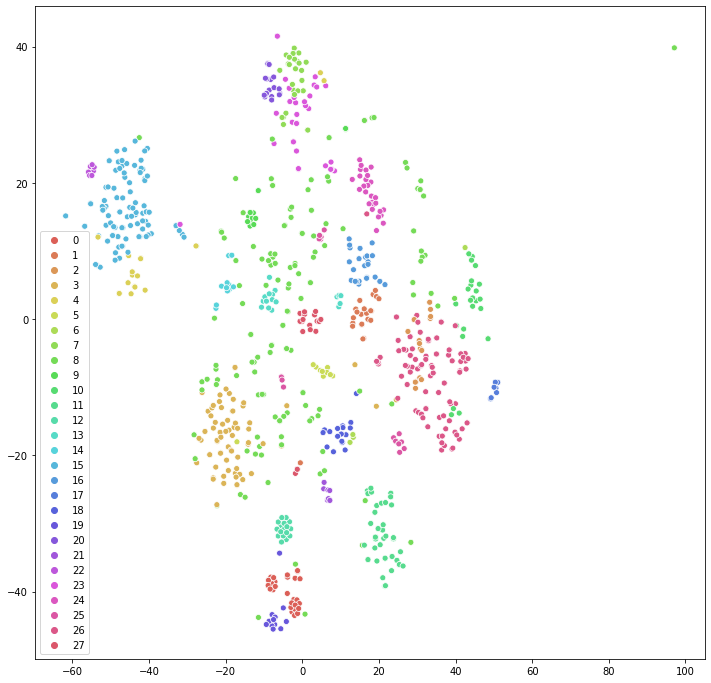

In [272]:
fig = plt.figure(figsize=[12,12])
sns.scatterplot(dense_tfidf_TSNE[:,0 ],
                dense_tfidf_TSNE[:,1],
                hue=cls28.labels_,
                legend='full',
                palette=sns.color_palette("hls",28))
plt.legend()

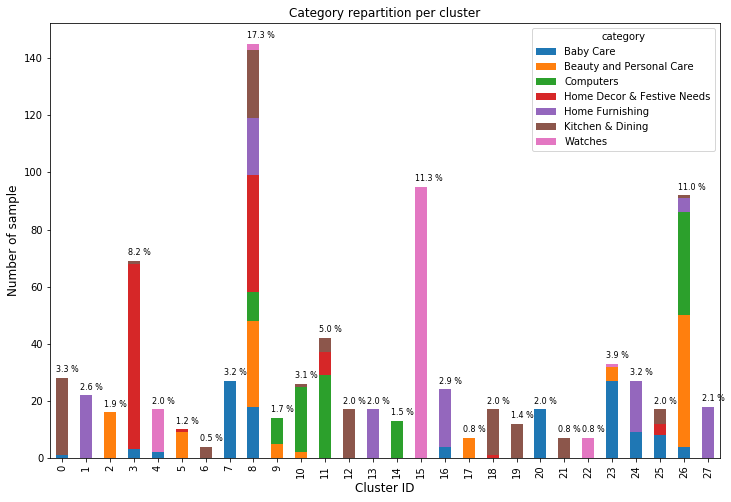

category  Baby Care  Beauty and Personal Care  Computers  \
label                                                      
0               1.0                       0.0        0.0   
1               0.0                       0.0        0.0   
2               0.0                      16.0        0.0   
3               3.0                       0.0        0.0   
4               2.0                       0.0        0.0   
5               0.0                       9.0        0.0   
6               0.0                       0.0        0.0   
7              27.0                       0.0        0.0   
8              18.0                      30.0       10.0   
9               0.0                       5.0        9.0   
10              0.0                       2.0       23.0   
11              0.0                       0.0       29.0   
12              0.0                       0.0        0.0   
13              0.0                       0.0        0.0   
14              0.0                       0.0       13.0   
15              0.0                       0.0        0.0   
16              4.0                       0.0        0.0   
17              0.0                       7.0        0.0   
18              0.0                       0.0        0.0   
19              0.0                       0.0        0.0   
20             17.0                       0.0        0.0   
21              0.0                       0.0        0.0   
22              0.0                       0.0        0.0   
23             27.0                       5.0        0.0   
24              9.0                       0.0        0.0   
25              8.0                       0.0        0.0   
26              4.0                      46.0       36.0   
27              0.0                       0.0        0.0   

category  Home Decor & Festive Needs  Home Furnishing  Kitchen & Dining  \
label                                                                     
0                                0.0              0.0              27.0   
1                                0.0             22.0               0.0   
2                                0.0              0.0               0.0   
3                               65.0              0.0               1.0   
4                                0.0              0.0               0.0   
5                                1.0              0.0               0.0   
6                                0.0              0.0               4.0   
7                                0.0              0.0               0.0   
8                               41.0             20.0              24.0   
9                                0.0              0.0               0.0   
10                               0.0              0.0               1.0   
11                               8.0              0.0               5.0   
12                               0.0              0.0              17.0   
13                               0.0             17.0               0.0   
14                               0.0              0.0               0.0   
15                               0.0              0.0               0.0   
16                               0.0             20.0               0.0   
17                               0.0              0.0               0.0   
18                               1.0              0.0              16.0   
19                               0.0              0.0              12.0   
20                               0.0              0.0               0.0   
21                               0.0              0.0               7.0   
22                               0.0              0.0               0.0   
23                               0.0              0.0               0.0   
24                               0.0             18.0               0.0   
25                               4.0              0.0               5.0   
26                               0.0              5.0               1.0   
27                      

In [273]:
observ_cluster(train,cls28.labels_)

In [274]:
clusters_common_words(dense_tfidf,cls28.labels_,tfidf_vectorizer.get_feature_names(),10)

Cluster 0  Cluster 1    Cluster 2    Cluster 3 Cluster 4    Cluster 5  \
0        mug      quilt          com    showpiece   digital    jewellery   
1     coffee  comforter     flipkart           cm     watch       vanity   
2    ceramic     single        combo         best       boy          box   
3    perfect        com          set       online       men         case   
4        tea   flipkart       online           30     india  compartment   
5       gift     floral       denver        price  discount       makeup   
6        one   abstract    guarantee    guarantee     great        pouch   
7  printland        buy           30  replacement      girl         body   
8       love    genuine  replacement          day    online           cm   
9        get       cash          day         ship       com         gift   

   Cluster 6 Cluster 7 Cluster 8    Cluster 9  ... Cluster 18   Cluster 19  \
0       hard      baby         1         skin  ...     kadhai          mug   
1     kadhai       boy        cm       laptop  ...          l      ceramic   
2    anodise    detail      inch        mouse  ...          5     prithish   
3          l     shirt     color        shape  ...       best         best   
4    anodize    sleeve      pack          pad  ...     kosher          day   
5        jsm    fabric   feature        print  ...     kalash       online   
6     sumeet    cotton       box     warranty  ...     online    guarantee   
7          3   regular         2  antiqueshop  ...      price           30   
8     wglass    casual  material        combo  ...  guarantee  replacement   
9  metallino       fit     model         inch  ...         30        price   

  Cluster 20 Cluster 21 Cluster 22 Cluster 23 Cluster 24  Cluster 25  \
0      dress      pizza       1100       baby      towel     sticker   
1       girl     cutter    timewel       girl       bath       vinyl   
2       baby      wheel     analog       hair     cotton      bottle   
3     gather       roll      watch     fabric        com     nutcase   
4     detail      steel        men      ideal   flipkart      medium   
5       line       apex   discount     cotton        set        wall   
6     length   tirupati      woman       neck       cash  wallmantra   
7     fabric   agromech      n2017          1    genuine        wrap   
8       neck      italy      n1192     detail       ship    adhesive   
9        wow      slice      n1685        top        buy       large   

    Cluster 26 Cluster 27  
0          com     eyelet  
1     flipkart    curtain  
2           30  polyester  
3    guarantee       door  
4         cash    comfort  
5      genuine     design  
6         ship      aroma  
7     delivery         cm  
8         free      duvet  
9  replacement       self  

[10 rows x 28 columns]

# Word Embedding (Doc2Vec)

In [10]:
# perform our preprocessing on both train and test datasets

train_doc2vec = nlp_preprocessing(train.description,english_sw,0,0)
test_doc2vec=nlp_preprocessing(test.description,english_sw,0,0)

In [11]:
len(train_doc2vec)

840

In [4]:
# Create a function so as to transform a each description of our list of description 
# into a TaggedDocument (which is mandatory to use doc2vec)

def corpus_doc2vec(corpus,categories):
    to_return = []
    for i in range(len(corpus)):
        to_return.append(doc2vec.TaggedDocument(train_doc2vec[i], categories[i]))
    
    return to_return
        


In [22]:
a=corpus_doc2vec(train_doc2vec,train.category)
a[0]

TaggedDocument(words=['specification', 'eternity', 'handcraft', 'unique', 'mosaic', 'glass', 'table', 'lamp', '35', 'cm', 'blue', 'box', 'sale', 'package', '1', 'table', 'lamp', 'number', 'content', 'sale', 'package', 'pack', '1', 'general', 'type', 'buffet', 'desk', 'color', 'blue', 'lamp', 'body', 'material', 'glass', 'lamp', 'base', 'material', 'metal', 'bulb', 'type', '1x15', 'lead', 'cfsl', 'bulb', 'light', 'color', 'blue', 'assembly', 'require', 'model', 'name', 'handcraft', 'unique', 'mosaic', 'glass', 'model', 'number', 'eternity001007', 'power', 'feature', 'power', 'requirement', '110', '240v', '50', '60hz', 'power', 'source', 'ac', 'additional', 'feature', 'handcraft', 'lamp', 'dimension', 'width', '15', 'cm', 'height', '35', 'cm', 'weight', '1000', 'g'], tags='Home Decor & Festive Needs')

Here is the list of actions performed by this function:
   * use the corpus_doc2vec function to create TaggedDocuments
   * train our doc2vec transformer on our train_dataset with the chosen method 
   
   
Parameters :
   * corpus : our list of descriptions
   * categories : list of categories which will be used to create TaggedDocument
   * method : 0 or 1 => 0 To choose method PV-DBOW, 1 To choose method PV-DM


In [5]:
def training_doc2vec(corpus,categories,method):
    train_corpus = corpus_doc2vec(train_doc2vec,categories)
    model = doc2vec.Doc2Vec(dm=method,vector_size=50, min_count=2, epochs=40)
    model.build_vocab(train_corpus)
    model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
    
    return model

## PV_DBOW

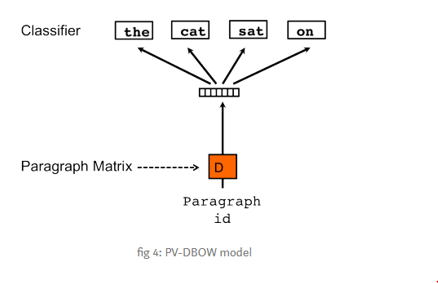

In [12]:
# Train PV-DBOW model 

model_doc2vec_dbow=training_doc2vec(train_doc2vec,train.category,0)

In [13]:
# Predict vector of our train dataset thanks to our trained doc2vec model

vector_train_dbow = [model_doc2vec_dbow.infer_vector(x) for x in train_doc2vec]

In [14]:
overview_train_dbow = pd.DataFrame(vector_train_dbow)

# Predict vector of our test dataset thanks to our trained doc2vec model

vector_test_dbow = [model_doc2vec_dbow.infer_vector(x) for x in test_doc2vec]
overview_test_dbow= pd.DataFrame(vector_test_dbow)

In [15]:
overview_train_dbow

0         1         2         3         4         5         6   \
0   -0.752089  0.625810  0.712341  0.504279 -0.042739  0.764388  0.649406   
1   -0.590869 -0.453418  0.739976 -0.596056 -0.694104 -1.050899 -0.340077   
2   -0.190488 -0.500217  0.133480 -0.732847 -0.099995  0.357324 -0.543260   
3   -0.313128 -0.113962  0.946227  0.086806 -0.265196 -0.969962  0.056832   
4    0.015245 -0.145425  0.092203  0.086680 -0.173309 -0.266989  0.376775   
..        ...       ...       ...       ...       ...       ...       ...   
835 -0.445500 -0.251938  0.479053 -0.093359 -0.290634 -0.634482  0.186179   
836 -0.188650  0.455360  0.442960 -0.181455 -0.181945 -0.663541  0.006654   
837  0.096661 -0.153633  0.777676  0.342453 -0.838181 -0.221918  0.304394   
838 -0.223151  1.072608  0.346015  0.161529 -0.463090  0.167980  0.407489   
839  0.304033 -0.276229  0.092886 -0.374332 -0.168360 -0.119007  0.962706   

           7         8         9   ...        40        41        42  \
0    0.558674 -0.272076  0.462149  ... -0.530454  0.364090  0.554465   
1   -0.897843  1.096338 -0.213361  ... -0.604061  0.972763  0.555475   
2   -0.596954  0.759942 -0.240097  ... -0.329081  1.410617  0.806392   
3   -1.191139 -0.448191 -0.446536  ... -0.143488  0.019502  0.094406   
4   -0.244692 -0.107901 -0.286424  ... -0.167717  0.387530 -0.127141   
..        ...       ...       ...  ...       ...       ...       ...   
835 -0.705746  0.234520 -0.005984  ... -0.162815  0.072084  0.181516   
836  0.518877 -0.870675 -0.413364  ... -0.491219  0.193887  0.233576   
837 -0.427061 -0.121388  0.123260  ... -0.184341  0.451132  0.398976   
838  0.145891 -0.146437 -0.070495  ... -0.569260  0.021736  0.509482   
839 -0.692223 -0.221837 -0.250258  ... -0.289090  0.269022  0.999856   

           43        44        45        46        47        48        49  
0    0.746014 -0.179351 -0.563640 -0.142906  1.711496 -0.652703  0.225153  
1    0.835665  0.850245 -0.757075 -0.940522  0.499159 -0.966849 -0.743132  
2    0.299624  0.262906 -1.728797 -0.462294  0.798194 -0.613130 -1.294218  
3   -0.109884 -0.028982 -0.262017  0.438544  0.630391  0.425982 -0.677412  
4   -0.166697 -0.163258 -0.631031 -0.433580  0.760800 -0.034712  0.071295  
..        ...       ...       ...       ...       ...       ...       ...  
835 -0.210244  0.213000 -0.534782 -0.192379  0.493819 -0.347354 -0.667106  
836 -0.042761  0.199042 -0.593404 -0.126323  0.469267 -0.251408  0.536881  
837 -0.773908 -0.238813 -0.947094 -0.042623  0.314028  0.142900 -0.668686  
838  0.048510  0.342909 -1.212275  0.070293  1.299097 -0.328105 -0.213832  
839 -1.166169  0.185804 -0.787097  0.273809  0.220538 -0.203234 -0.160070  

[840 rows x 50 columns]

In [45]:
parameters = {"n_estimators": [100,150,200],  #Number of tree to build
              "max_depth": np.linspace(10, 110, num = 4),   # Max depth of the tree
              "min_samples_leaf": [1,3,5],#min amount of sample to have both left and right to a node
              "max_features":['auto', 'sqrt'] # additionnal source of random (max feature available 
                                                                     # when looking at feature for best split)
             } 

# tfidf_rfr_pipe = make_pipeline(TfidfVectorizer(encoding='utf-8',
#                                              lowercase=True,
#                                              tokenizer=LemmaTokenizer()),
#                              RandomForestClassifier())

doc2vec_rfr_grid_dbow = GridSearchCV(estimator = RandomForestClassifier(), 
                              param_grid = parameters,
                              scoring ='accuracy' ,
                              cv=5)

doc2vec_rfr_grid_dbow.fit(overview_train_dbow, train.category)

doc2vec_classifier_dbow = doc2vec_rfr_grid_dbow.best_estimator_


print('Validation Score (accuracy): ',doc2vec_rfr_grid_dbow.best_score_)

print('\nBest Params: ',doc2vec_rfr_grid_dbow.best_params_)

print('\nTest Score (accuracy): ',accuracy_score(test.category,doc2vec_classifier_dbow.predict(overview_test_dbow)))

Validation Score (accuracy):  0.9892857142857142

Best Params:  {'max_depth': 10.0, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200}

Test Score (accuracy):  0.9238095238095239


In [24]:
scoring =['accuracy','recall_macro','precision_macro','f1_macro']

summary_pvdbow = pd.DataFrame(index=['train','test'],columns=scoring)

for score in scoring:
    
    summary_pvdbow.loc['train',score]=cross_val_score(doc2vec_classifier_dbow,
                                                     overview_train_dbow,
                                                     train.category,
                                                     scoring=score,
                                                     cv=5).mean()

    
summary_pvdbow.loc['test','accuracy']=accuracy_score(test.category,
                                                    doc2vec_classifier_dbow.predict(overview_test_dbow))

summary_pvdbow.loc['test','recall_macro']=recall_score(test.category,
                                                      doc2vec_classifier_dbow.predict(overview_test_dbow),
                                                      average='macro')

summary_pvdbow.loc['test','precision_macro']=precision_score(test.category,
                                                            doc2vec_classifier_dbow.predict(overview_test_dbow),
                                                            average='macro')

summary_pvdbow.loc['test','f1_macro']=f1_score(test.category,
                                              doc2vec_classifier_dbow.predict(overview_test_dbow),
                                              average='macro')

summary_pvdbow

accuracy recall_macro precision_macro  f1_macro
train  0.982143     0.986905        0.981684  0.984432
test   0.909524     0.909524        0.914612  0.909219

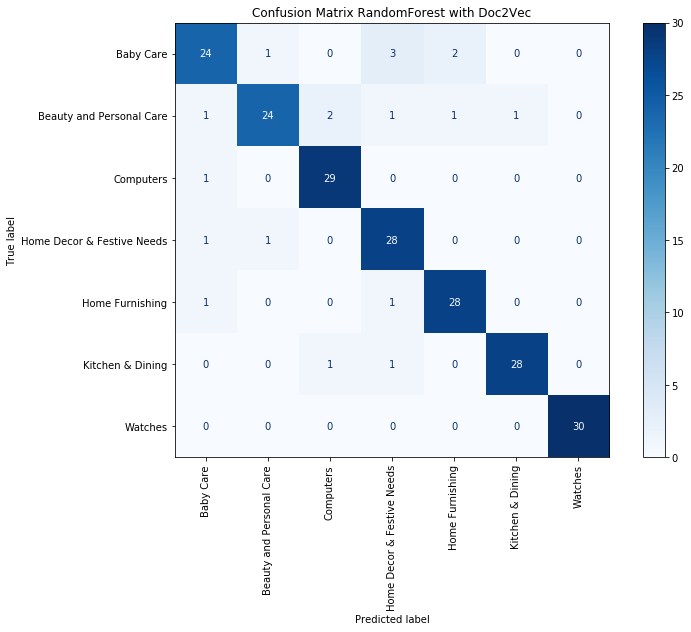

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))

plot_confusion_matrix(doc2vec_classifier_dbow,
                      overview_test_dbow,
                      test.category,
                      ax=ax,
                      xticks_rotation=90,
                      cmap='Blues') 

ax.set_title('Confusion Matrix RandomForest with Doc2Vec')
plt.show()  

In [20]:
overview_test_dbow

0         1         2         3         4         5         6   \
0   -0.579980  0.317345 -0.378038  0.428423 -0.618370 -0.229084  0.391930   
1   -0.197438  0.207787 -0.529050 -0.242913 -0.277825 -0.241616  0.151061   
2   -0.209046 -0.386061 -0.632780  0.031287  0.577987 -0.419627  0.483777   
3    0.125724  0.349313 -0.056965  0.316759  0.318970 -0.528873  0.149045   
4   -0.527923 -0.137991  1.039181  0.696519 -0.410072 -0.873846  0.093386   
..        ...       ...       ...       ...       ...       ...       ...   
205 -0.297280  0.000326  0.174441  0.038275 -0.561663 -0.321940  0.187692   
206 -1.163578 -1.030957  0.220551  0.696436 -0.723676  0.361506  0.418472   
207 -0.266295 -0.143795 -0.323759  0.281100 -0.320423 -0.628370  0.258122   
208 -0.623995  0.915677 -0.460794 -0.712369 -0.302071 -0.911265 -1.286441   
209 -0.593000 -0.450715 -0.192066  0.073738 -0.243916  0.100185  0.762901   

           7         8         9   ...        40        41        42  \
0   -0.534607 -0.785833  0.060749  ... -0.051020 -0.062450  0.198346   
1   -0.446320  0.055157 -1.275869  ... -0.118556  0.085270  0.711692   
2   -0.714412  0.211336 -0.648440  ...  0.009115 -0.041306  1.274305   
3    0.194855  0.060519 -0.122096  ... -1.266417  0.190621  0.552798   
4   -0.402987  0.936755  0.414363  ...  0.200489  0.669112  0.682904   
..        ...       ...       ...  ...       ...       ...       ...   
205 -0.045399 -0.049586 -0.579000  ...  0.056542  0.093355  0.537378   
206  0.060673 -0.670473  0.203435  ... -0.408470  0.420937  0.132884   
207 -0.361236 -0.234257  0.355344  ... -0.292145  0.422574 -0.151680   
208 -0.042198 -0.620616 -1.162767  ...  0.567027  0.102422 -0.751657   
209  0.298919 -1.008241 -0.361290  ...  0.377458  0.415389 -0.085822   

           43        44        45        46        47        48        49  
0   -0.495044  0.027434 -0.569640  0.113574  0.012473  0.220903 -0.439174  
1    0.271539 -1.011970 -0.127112 -0.258049 -0.095664 -0.064135 -0.482669  
2   -0.449455  0.560445 -1.339249  0.467446  0.172190  0.404519 -0.567312  
3   -0.081293 -0.112642 -0.498425 -0.080546  0.750712 -0.322670 -0.739022  
4    0.719389  0.615647 -0.672615 -0.534142  0.614573 -0.786671 -1.026366  
..        ...       ...       ...       ...       ...       ...       ...  
205 -0.776635 -0.325356 -0.941007  0.296677  0.333422 -0.276547 -0.510871  
206  0.470739  0.812627 -0.037811 -0.307967  0.623468  0.820677 -1.077876  
207 -0.213816 -0.060071 -0.193498 -0.048386  0.245815  0.363198 -0.187155  
208  1.178387  0.337067 -0.171439  0.390934  0.265429 -0.769839  0.377455  
209 -0.313124 -0.499680 -0.540676  0.381756  0.970745  0.146994 -0.725989  

[210 rows x 50 columns]

In [19]:
# Save RandomForestClassifier

with open('doc2vecmodel2.pickle', 'wb') as file:
    pickle.dump(doc2vec_classifier_dbow, file)

In [22]:
# Save our doc2vec model

with open('word_embedding.pickle', 'wb') as file:
    pickle.dump(model_doc2vec_dbow, file)

## PV_DM

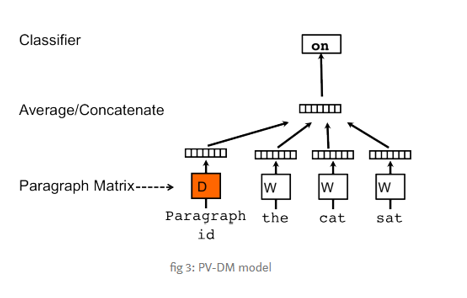

In [46]:
# Train PV-DM model 

model_doc2vec_dm=training_doc2vec(train_doc2vec,train.category,1)

In [47]:
# Predict vector of our train dataset thanks to our trained doc2vec model

vector_train_dm = [model_doc2vec_dm.infer_vector(x) for x in train_doc2vec]

In [48]:
overview_train_dm = pd.DataFrame(vector_train_dm)

# Predict vector of our test dataset thanks to our trained doc2vec model

vector_test_dm = [model_doc2vec_dm.infer_vector(x) for x in test_doc2vec]
overview_test_dm= pd.DataFrame(vector_test_dm)

In [45]:
overview_train_dm

0         1         2         3         4         5         6   \
0   -0.783387  0.060946 -1.809213  1.354821  1.066611  0.968665  0.013375   
1    0.287022  0.133393 -1.495490  0.763345  0.754225 -0.422222 -0.851831   
2   -1.351921  1.546296 -0.807075 -0.296657  2.774020  1.897708 -0.224829   
3    0.131270  0.301187 -1.293513  1.203983 -0.479992  0.464629  0.012359   
4    0.143014 -0.235638 -0.843658  1.059192  0.127261  0.259017 -0.014547   
..        ...       ...       ...       ...       ...       ...       ...   
835  0.122889 -0.001034 -1.499880  1.694494  0.060607  0.450306 -0.060100   
836 -0.214641 -0.315028 -1.207672  1.466682  0.348728  0.310347  0.514454   
837  0.008211  0.121955 -0.814696  0.784312 -0.226243  0.893559  0.301191   
838  0.093247 -0.149964 -0.929723  1.442985 -0.571261  0.615538  0.469099   
839  0.022461 -0.411794 -0.996161  1.163064  0.362603  0.276920  0.105699   

           7         8         9   ...        40        41        42  \
0    1.150596 -0.730177 -0.995093  ...  2.093172  0.196565 -0.529107   
1    0.823400 -1.537232  0.195377  ...  0.836439  0.197201 -0.281560   
2    1.189713  0.841006  0.951717  ...  1.973940 -0.122294 -0.698897   
3    0.505303 -1.101884 -0.121768  ...  0.389260 -0.013798  0.142922   
4    0.488549 -0.725216 -0.077405  ... -0.103264 -0.100963  0.165545   
..        ...       ...       ...  ...       ...       ...       ...   
835  0.719370 -1.368466 -0.330356  ...  0.057637 -0.306758 -0.054310   
836  1.069051 -1.113926  0.192735  ...  0.163654 -0.319949 -0.225208   
837  0.693909 -0.779798 -0.070004  ... -0.251208 -0.151833  0.220614   
838  0.937628 -1.145044 -0.508054  ... -0.201002 -0.185626  0.337608   
839  1.022131 -0.693700  0.118929  ... -0.063962 -0.108963 -0.032278   

           43        44        45        46        47        48        49  
0    0.211303  0.893458 -2.056495 -2.047088  2.635187  1.395689  0.079602  
1    0.345569  1.968481 -1.235277 -1.928751  0.996516  0.653471  0.356708  
2    1.439127 -0.235839 -1.077757 -2.312318  2.345197  2.570022  0.461939  
3   -0.277222  1.020964 -0.376851 -1.042892  0.231286  1.367571 -0.870912  
4   -0.177201  0.513467 -0.304852 -0.482510  0.568610  0.301997 -0.098099  
..        ...       ...       ...       ...       ...       ...       ...  
835 -0.057466  0.864911 -0.721793 -1.150865  0.438411  1.045134 -0.563054  
836 -0.153720  1.256143 -0.822291 -0.834457  1.060733  0.632874 -0.360997  
837 -0.374174  0.193622 -0.508105 -0.512713  0.412132  0.755370 -0.586477  
838 -0.872283  0.484006 -0.593421 -0.414077  0.296493  0.878565 -0.972162  
839 -0.020832  0.719031 -0.936621 -0.688050  0.937441  0.399880  0.071876  

[840 rows x 50 columns]

In [49]:
overview_train_dm

0         1         2         3         4         5         6   \
0    1.238022 -1.555662  1.886779  0.444149  2.754641 -2.864271  0.597450   
1    1.559205 -0.475962  1.085731 -0.507352  1.406382 -0.935081  0.022811   
2    0.971664 -2.535073  2.340248 -0.642731  2.470859 -0.670340  0.865724   
3    0.785332  0.399239 -0.315943 -1.015385  1.275150 -1.061023  0.787480   
4    1.061055 -0.018120 -0.019788 -0.530799  0.954854 -0.600731 -0.049819   
..        ...       ...       ...       ...       ...       ...       ...   
835  1.370848  0.235101  0.085421 -1.066199  1.589401 -1.034589  0.513212   
836  1.727182 -0.037340  0.337248 -1.716304  1.495398 -1.350765 -0.535655   
837  0.418376 -0.143262  0.251768 -0.688260  1.429873 -0.851471 -0.298581   
838  0.428412 -0.113033 -0.286311 -0.388248  1.496454 -1.454584 -0.027718   
839  1.477199 -0.276364  0.457621 -1.179641  1.204621 -1.144521 -0.568738   

           7         8         9   ...        40        41        42  \
0    1.382162  3.805536 -1.438381  ... -3.217323  0.387309  1.141268   
1    2.115413  1.014576 -1.356794  ... -0.876935  0.523464  0.245764   
2    0.695828  3.586471 -0.866326  ... -2.838522  0.795869 -0.106150   
3    1.225270  0.189480 -1.162796  ... -1.253588  0.667134  0.652391   
4    0.924078  0.337546 -0.592737  ... -0.465911  0.211551  0.178858   
..        ...       ...       ...  ...       ...       ...       ...   
835  1.438703  0.434119 -1.109443  ... -1.161387  0.327113  0.441920   
836  1.121846  0.592694 -1.894598  ... -1.284964  0.350013  0.251312   
837  0.396662  0.953709 -0.979573  ... -0.795219  0.128990  0.623987   
838  0.472723  0.887409 -1.143864  ... -0.799393  0.027624  0.950225   
839  1.090260  0.640787 -1.617610  ... -0.794725  0.120749  0.046182   

           43        44        45        46        47        48        49  
0    1.648673  0.260881 -1.710971  0.760781  3.581266 -1.634863  1.980731  
1    0.219981  0.556236 -1.542283 -1.331061  1.649391 -0.722518  0.737749  
2    0.169384 -0.016515 -1.380240 -2.058055  0.807579 -2.572565  0.115872  
3   -0.385055 -0.226443 -0.684754 -1.103278  1.589164 -0.301060  0.156154  
4   -0.174821 -0.314365  0.125255 -0.518531  0.490390 -0.160032  0.312088  
..        ...       ...       ...       ...       ...       ...       ...  
835 -0.332352 -0.279853 -0.336185 -0.963317  1.109618 -0.284452  0.719956  
836 -0.017925 -0.507083 -0.354476 -0.314781  0.679730 -0.597090  0.818688  
837 -0.347859 -0.030356  0.123399 -0.724667  0.878682 -0.230309 -0.197810  
838 -0.138845  0.067417 -0.286644 -0.009552  1.429624  0.054300  0.206106  
839 -0.114961 -0.482685 -0.068639 -0.598687  0.555887 -0.510954  0.534272  

[840 rows x 50 columns]

In [50]:
parameters = {"n_estimators": [100,150,200],  #Number of tree to build
              "max_depth": np.linspace(10, 110, num = 4),   # Max depth of the tree
              "min_samples_leaf": [1,3,5],#min amount of sample to have both left and right to a node
              "max_features":['auto', 'sqrt'] # additionnal source of random (max feature available 
                                                                     # when looking at feature for best split)
             } 

# tfidf_rfr_pipe = make_pipeline(TfidfVectorizer(encoding='utf-8',
#                                              lowercase=True,
#                                              tokenizer=LemmaTokenizer()),
#                              RandomForestClassifier())

doc2vec_rfr_grid_dm = GridSearchCV(estimator = RandomForestClassifier(), 
                              param_grid = parameters,
                              scoring ='accuracy' ,
                              cv=5)

doc2vec_rfr_grid_dm.fit(overview_train_dm, train.category)

doc2vec_classifier_dm = doc2vec_rfr_grid_dm.best_estimator_


print('Validation Score (accuracy): ',doc2vec_rfr_grid_dm.best_score_)

print('\nBest Params: ',doc2vec_rfr_grid_dm.best_params_)

print('\nTest Score (accuracy): ',accuracy_score(test.category,doc2vec_classifier_dm.predict(overview_test_dm)))

Validation Score (accuracy):  0.936904761904762

Best Params:  {'max_depth': 110.0, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 150}

Test Score (accuracy):  0.7761904761904762


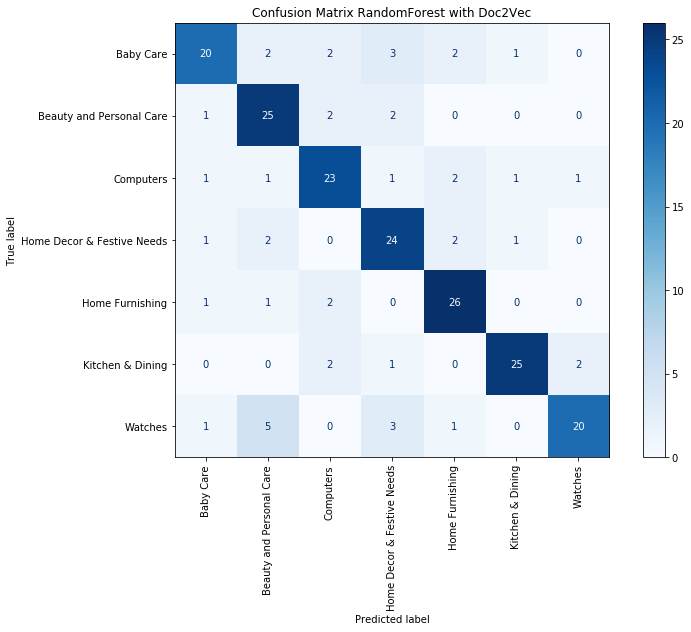

In [52]:
fig, ax = plt.subplots(figsize=(12, 8))

plot_confusion_matrix(doc2vec_classifier_dm,
                      overview_test_dm,
                      test.category,
                      ax=ax,
                      xticks_rotation=90,
                      cmap='Blues') 

ax.set_title('Confusion Matrix RandomForest with Doc2Vec')
plt.show()  

# BERT

## Bert base nli mean tokens

In [51]:
#Load BertModel

model = SentenceTransformer('distilbert-base-nli-mean-tokens')

100%|██████████| 245M/245M [03:43<00:00, 1.10MB/s] 


In [52]:
# Encode Train 

train_bert = model.encode(train.description)

In [53]:
#Encode Test

test_bert = model.encode(test.description)

In [54]:
train_bert

array([[-0.36522153, -0.40078947,  0.09296708, ..., -0.21925028,
        -0.06930177, -0.9405021 ],
       [-0.83299226, -0.9669176 ,  0.38453537, ...,  0.263504  ,
         0.7693681 ,  0.3072249 ],
       [-0.13446943, -0.68987304,  0.91931665, ..., -0.67153794,
        -0.01435632, -0.27596965],
       ...,
       [-0.6792214 , -0.7732874 ,  0.25096804, ...,  0.32005998,
         0.3549293 , -0.09758098],
       [-0.36811697, -0.54143316,  0.5840916 , ...,  0.08861896,
         0.25916472,  0.04142262],
       [-0.4431913 , -0.59286886,  0.11217368, ...,  0.21612704,
         0.21754526, -0.09276798]], dtype=float32)

In [55]:
parameters = {"n_estimators": [100,150,200],  #Number of tree to build
              "max_depth": np.linspace(10, 110, num = 4),   # Max depth of the tree
              "min_samples_leaf": [1,3,5],#min amount of sample to have both left and right to a node
              "max_features":['auto', 'sqrt'] # additionnal source of random (max feature available 
                                                                     # when looking at feature for best split)
             } 

# tfidf_rfr_pipe = make_pipeline(TfidfVectorizer(encoding='utf-8',
#                                              lowercase=True,
#                                              tokenizer=LemmaTokenizer()),
#                              RandomForestClassifier())

doc2vec_rfr_grid_bert = GridSearchCV(estimator = RandomForestClassifier(), 
                              param_grid = parameters,
                              scoring ='accuracy' ,
                              cv=5)

doc2vec_rfr_grid_bert.fit(train_bert, train.category)

doc2vec_classifier_bert = doc2vec_rfr_grid_bert.best_estimator_


print('Validation Score (accuracy): ',doc2vec_rfr_grid_bert.best_score_)

print('\nBest Params: ',doc2vec_rfr_grid_bert.best_params_)

print('\nTest Score (accuracy): ',accuracy_score(test.category,doc2vec_classifier_bert.predict(test_bert)))

Validation Score (accuracy):  0.9011904761904763

Best Params:  {'max_depth': 110.0, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 200}

Test Score (accuracy):  0.8952380952380953


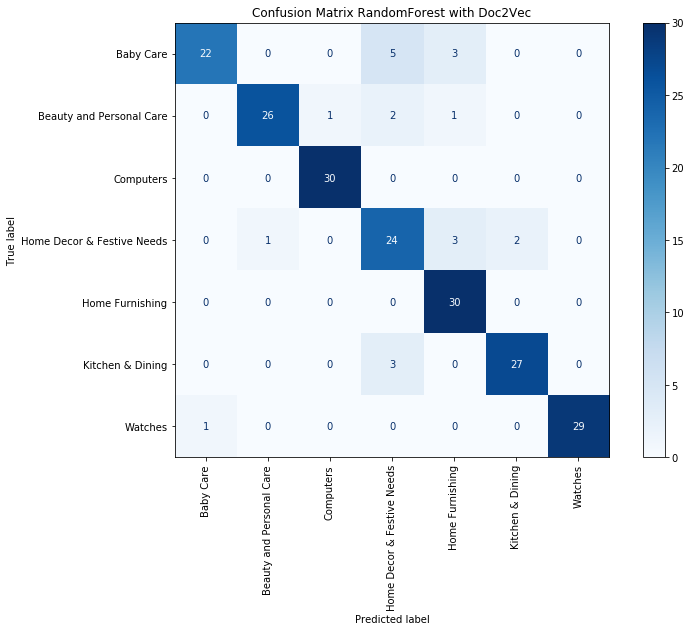

In [56]:
fig, ax = plt.subplots(figsize=(12, 8))

plot_confusion_matrix(doc2vec_classifier_bert,
                      test_bert,
                      test.category,
                      ax=ax,
                      xticks_rotation=90,
                      cmap='Blues') 

ax.set_title('Confusion Matrix RandomForest with Doc2Vec')
plt.show()  

## Bert Larg nli mean tokens

In [57]:
model = SentenceTransformer('bert-large-nli-mean-tokens')
train_bert = model.encode(train.description)
test_bert = model.encode(test.description)

100%|██████████| 1.24G/1.24G [30:02<00:00, 690kB/s]  


In [58]:
parameters = {"n_estimators": [100,150,200],  #Number of tree to build
              "max_depth": np.linspace(10, 110, num = 4),   # Max depth of the tree
              "min_samples_leaf": [1,3,5],#min amount of sample to have both left and right to a node
              "max_features":['auto', 'sqrt'] # additionnal source of random (max feature available 
                                                                     # when looking at feature for best split)
             } 

# tfidf_rfr_pipe = make_pipeline(TfidfVectorizer(encoding='utf-8',
#                                              lowercase=True,
#                                              tokenizer=LemmaTokenizer()),
#                              RandomForestClassifier())

doc2vec_rfr_grid_bert = GridSearchCV(estimator = RandomForestClassifier(), 
                              param_grid = parameters,
                              scoring ='accuracy' ,
                              cv=5)

doc2vec_rfr_grid_bert.fit(train_bert, train.category)

doc2vec_classifier_bert = doc2vec_rfr_grid_bert.best_estimator_


print('Validation Score (accuracy): ',doc2vec_rfr_grid_bert.best_score_)

print('\nBest Params: ',doc2vec_rfr_grid_bert.best_params_)

print('\nTest Score (accuracy): ',accuracy_score(test.category,doc2vec_classifier_bert.predict(test_bert)))

Validation Score (accuracy):  0.8880952380952379

Best Params:  {'max_depth': 76.66666666666667, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200}

Test Score (accuracy):  0.8952380952380953


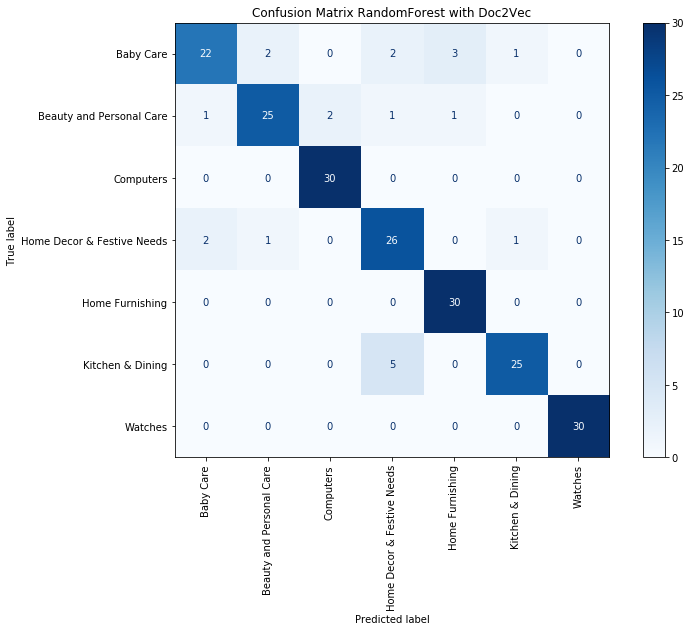

In [59]:
fig, ax = plt.subplots(figsize=(12, 8))

plot_confusion_matrix(doc2vec_classifier_bert,
                      test_bert,
                      test.category,
                      ax=ax,
                      xticks_rotation=90,
                      cmap='Blues') 

ax.set_title('Confusion Matrix RandomForest with Doc2Vec')
plt.show()  

___

<p style="font-size:18px"><b>The next step of our project is the image classification part, which can be found in the P06_02 section </p></b>